# Лабораторна робота №4
## Баштового Івана
## Варіант № 14
# Тема :
## Побудова моделi згорткових нейронних мереж для класифiкацiї зображень в TensorFlow

# Мета роботи:

## • Навчитися створювати моделi згорткових нейронних мереж за допомогою бi-блiотеки TensorFlow та API Keras.

## • Використати згорткову нейронну мережу для класифiкацiї чорно-бiлих та ко-льорових зображень.

## • Порiвняти результати з результатами на основi моделi MLP.

## • Для представлення результатiв використати TensorBoard.

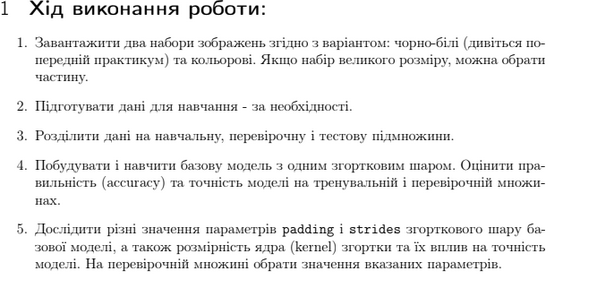

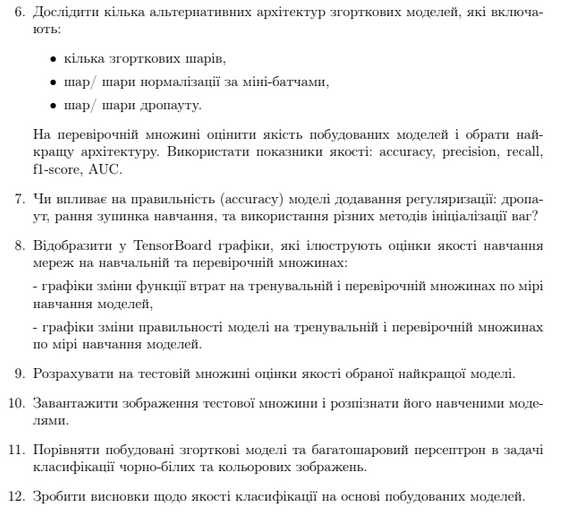

### Варіант 14 -  5 Flower Types Classification Dataset, kaggle.com

## Load Libraries

In [86]:
import numpy as np
import pandas as pd
import os
import itertools
from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.utils import to_categorical


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adamax
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard



import warnings
warnings.filterwarnings("ignore")


## Data Preprocessing


In [36]:
data_dir = "flower_images"

filepaths = []
labels = []

# List subdirectories (folds) excluding any non-directory files
folds = [fold for fold in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, fold))]

for fold in folds:
    foldpaths = os.path.join(data_dir, fold)
    filelists = os.listdir(foldpaths)
    
    for file in filelists:
        if file != '.DS_Store':  # Skip .DS_Store files
            filepath= os.path.join(foldpaths, file)
        
            filepaths.append(filepath)
            labels.append(fold)
        
Fseries = pd.Series(filepaths, name='Filepath')
Lseries = pd.Series(labels, name='Label')

df = pd.concat([Fseries, Lseries], axis=1)
df.head()

Filepath  Label
0  flower_images/Lotus/16905dde87.jpg  Lotus
1  flower_images/Lotus/839f7d1a14.jpg  Lotus
2  flower_images/Lotus/6acf5327ad.jpg  Lotus
3  flower_images/Lotus/327793cdf0.jpg  Lotus
4  flower_images/Lotus/c8e4698aa0.jpg  Lotus

<Axes: xlabel='Label', ylabel='Count'>

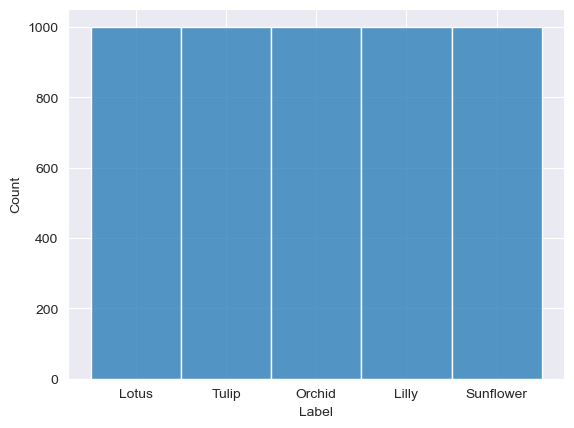

In [37]:
sns.histplot(df["Label"])

In [38]:
# Function to reduce the number of samples by half while keeping class balance
def reduce_samples_by_half(df):
    unique_labels = df['Label'].unique()
    reduced_df = pd.DataFrame(columns=['Filepath', 'Label'])

    for label in unique_labels:
        temp_df = df[df['Label'] == label]
        reduced_temp_df = temp_df.sample(frac=0.5)
        reduced_df = pd.concat([reduced_df, reduced_temp_df], axis=0)

    return reduced_df.reset_index(drop=True)


In [39]:
reduced_df = reduce_samples_by_half(df)
reduced_df.head()

Filepath  Label
0  flower_images/Lotus/e2b8333e52.jpg  Lotus
1  flower_images/Lotus/c60eb3796d.jpg  Lotus
2  flower_images/Lotus/fd59d80757.jpg  Lotus
3  flower_images/Lotus/a2b907b6d6.jpg  Lotus
4  flower_images/Lotus/bf356d0a39.jpg  Lotus

<Axes: xlabel='Label', ylabel='Count'>

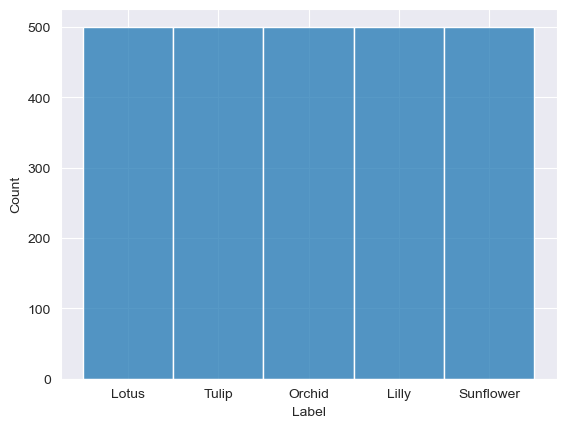

In [40]:
sns.histplot(reduced_df["Label"])

## Split data into train, valid & test


In [41]:
train_df, dummy_df = train_test_split(df, test_size=0.2, shuffle= True, random_state= 42,
                                     stratify= df['Label'])

valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle= True, random_state= 42,
                                    stratify= dummy_df['Label'])

In [42]:
print(f"Train shape = {train_df.shape}")
print(f"Valid shape = {valid_df.shape}")
print(f"Test shape = {test_df.shape}")

Train shape = (4000, 2)
Valid shape = (500, 2)
Test shape = (500, 2)


## Create image data generator


In [47]:

batch_size = 16
image_size = (224, 224)


# No Data augmentation for training data

train_generator = ImageDataGenerator(
    rescale=1.0/255
)

# # Data augmentation for training data
# train_generator = ImageDataGenerator(b
#     rescale=1.0/255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Only rescaling for validation and test data
validation_generator = ImageDataGenerator(rescale=1.0/255)
test_generator = ImageDataGenerator(rescale=1.0/255)

# Flow from DataFrame
train_generator = train_generator.flow_from_dataframe(
    train_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='rgb',
    batch_size=batch_size, 
    target_size=image_size
)

validation_generator = validation_generator.flow_from_dataframe(
    valid_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='rgb',
    batch_size=batch_size, 
    target_size=image_size
)

test_generator = test_generator.flow_from_dataframe(
    test_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='rgb',
    batch_size=batch_size, 
    target_size=image_size
)


Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


## Show sample from train data


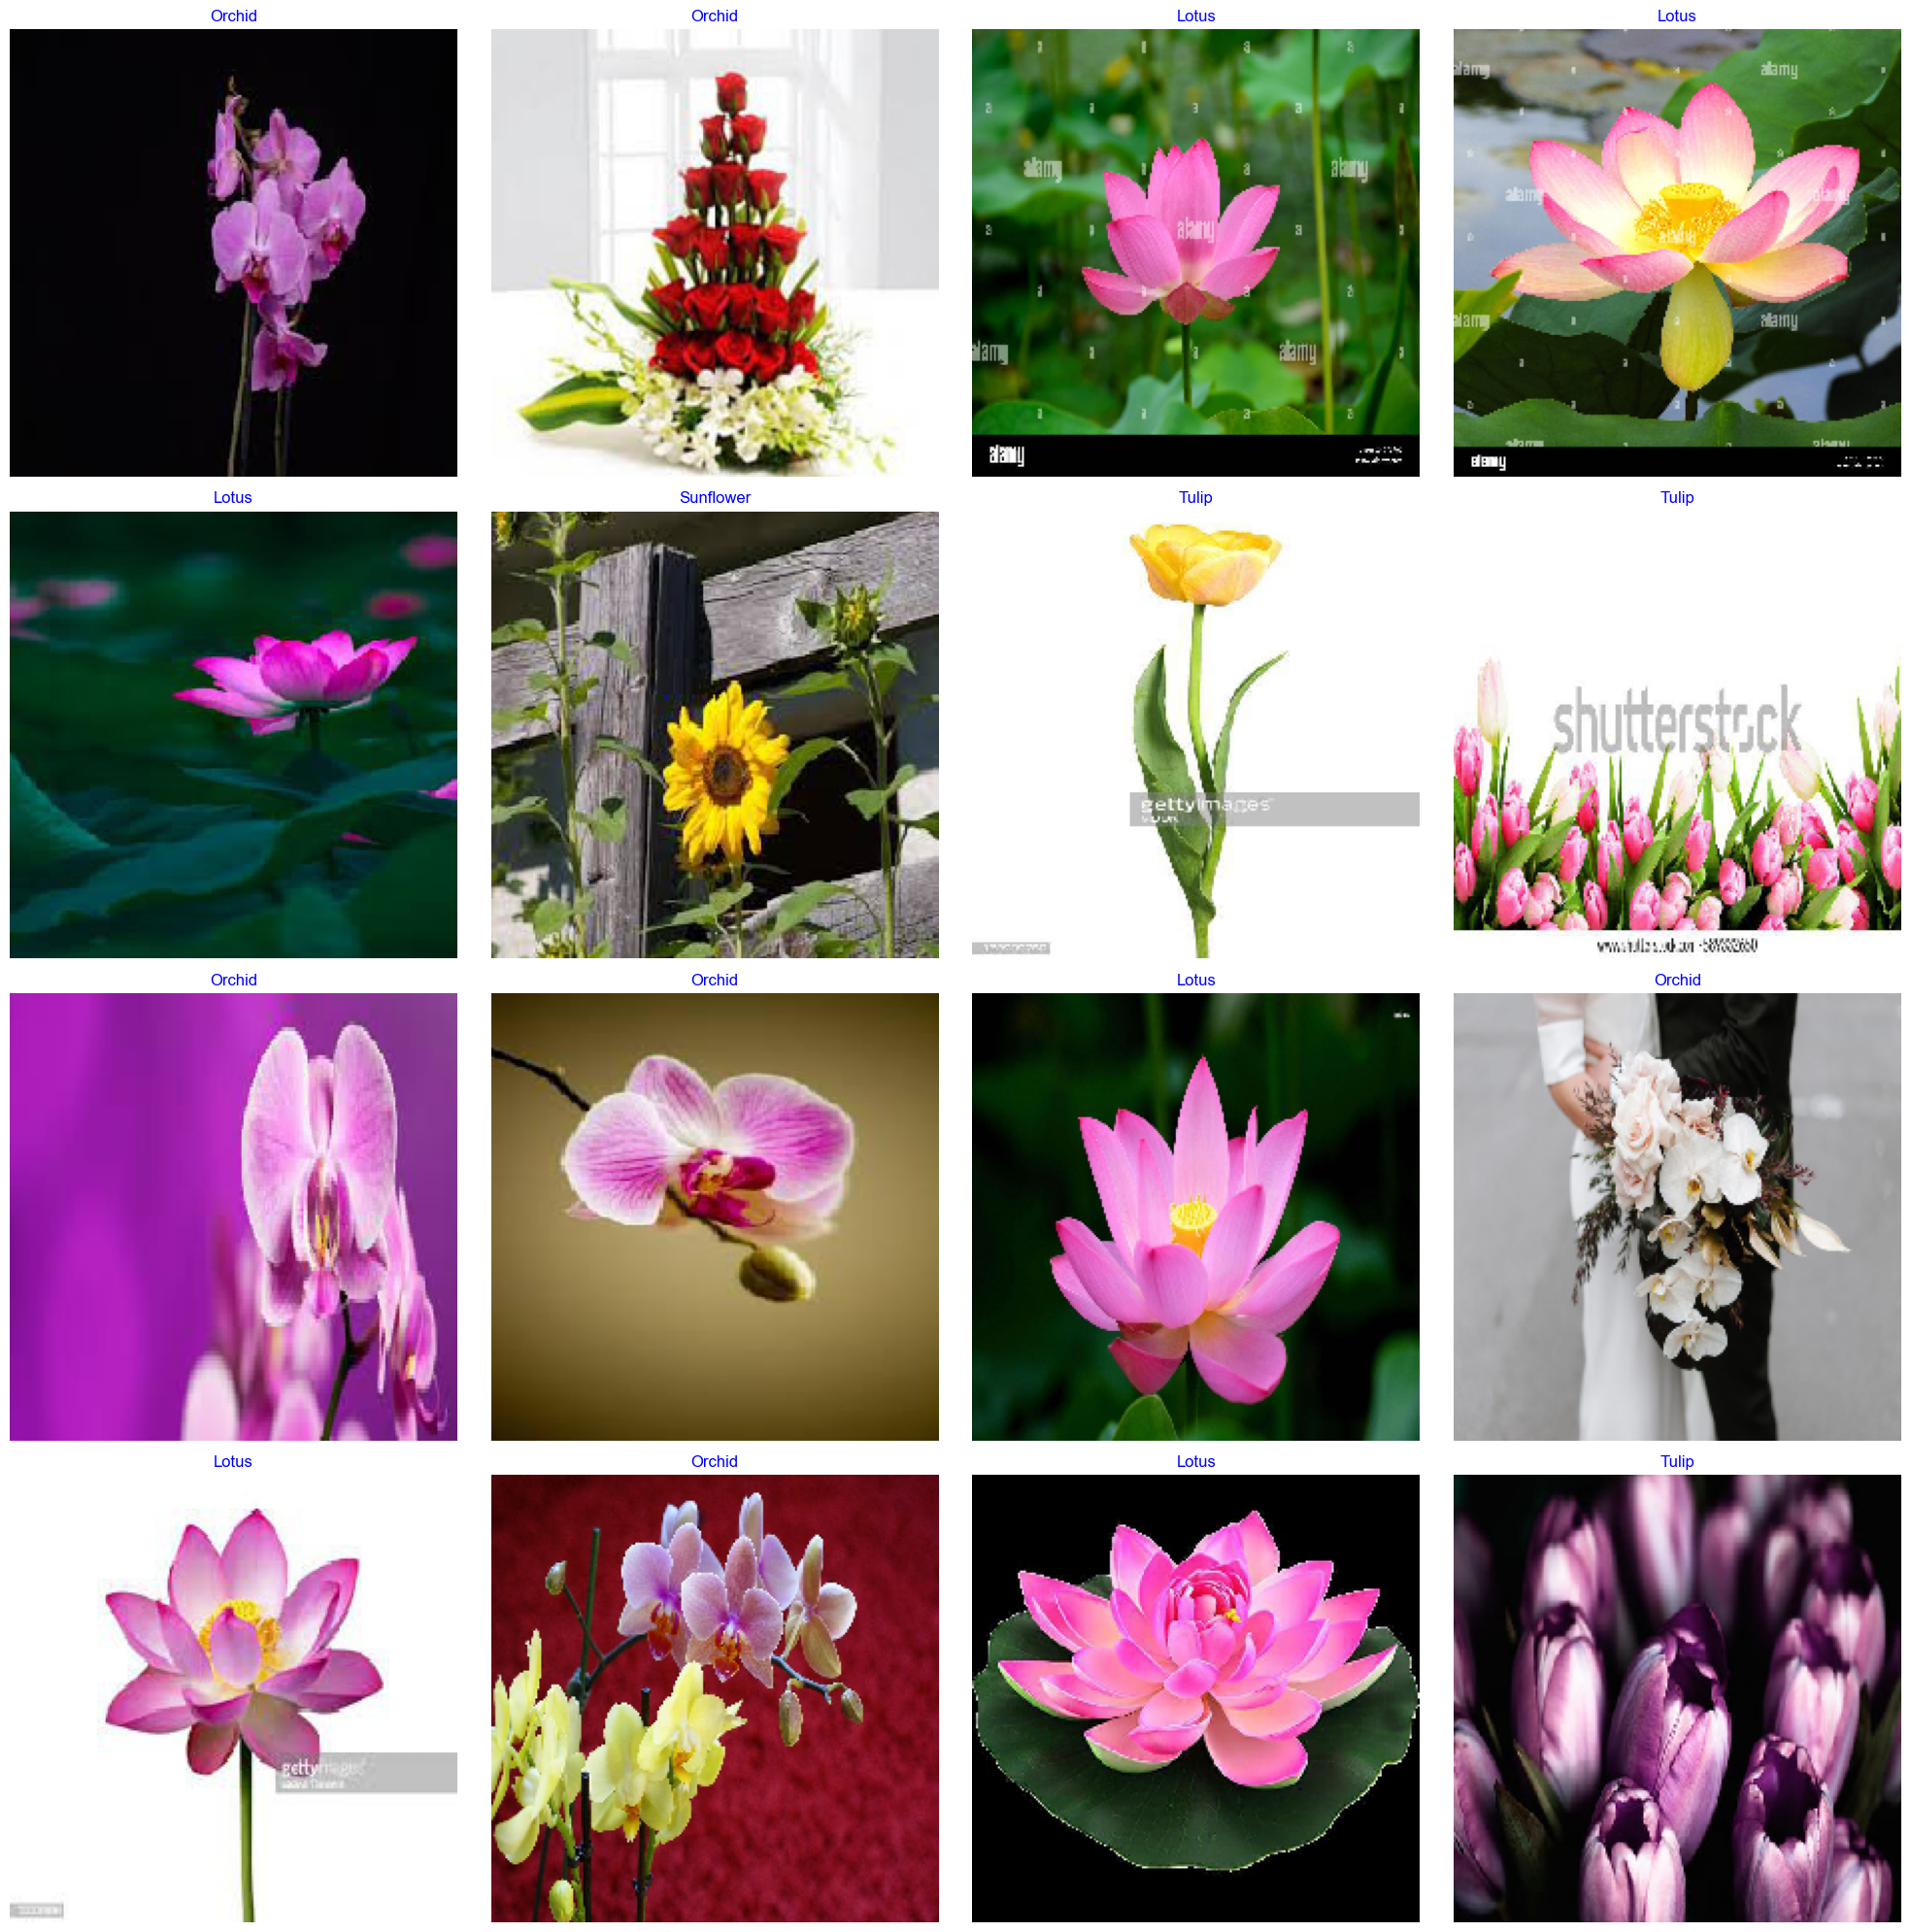

In [49]:
gen_dict = train_generator.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_generator)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]  
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes_name[index]  
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Build a Basic CNN Model
#### Let's start with a basic model with a single convolutional layer:

In [51]:
basic_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(5, activation='softmax')  
])

basic_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_basic_cnn = basic_cnn.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


2024-05-18 14:44:40.129401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


249/250 [============================>.] - ETA: 0s - loss: 1.7889 - accuracy: 0.5670

2024-05-18 14:44:52.329147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 14s 55ms/step - loss: 1.7851 - accuracy: 0.5680 - val_loss: 0.9673 - val_accuracy: 0.6880
Epoch 2/10
250/250 [==============================] - 14s 54ms/step - loss: 0.5329 - accuracy: 0.8380 - val_loss: 0.8986 - val_accuracy: 0.7180
Epoch 3/10
250/250 [==============================] - 14s 55ms/step - loss: 0.1921 - accuracy: 0.9560 - val_loss: 0.7536 - val_accuracy: 0.7680
Epoch 4/10
250/250 [==============================] - 14s 54ms/step - loss: 0.0799 - accuracy: 0.9863 - val_loss: 0.7312 - val_accuracy: 0.7960
Epoch 5/10
250/250 [==============================] - 14s 54ms/step - loss: 0.0754 - accuracy: 0.9893 - val_loss: 0.6578 - val_accuracy: 0.8140
Epoch 6/10
250/250 [==============================] - 14s 54ms/step - loss: 0.0514 - accuracy: 0.9918 - val_loss: 0.8710 - val_accuracy: 0.8060
Epoch 7/10
250/250 [==============================] - 14s 55ms/step - loss: 0.0684 - accuracy: 0.9915 - val_loss: 0.8023 - val_accuracy: 0.7780
Epo

We see that our model overfits, therefore, we can assume that adding dropout will work well. 

## Investigate Hyperparameters
#### Explore different values for padding, strides, and kernel_size:

In [53]:
# Define a function to create models with different parameters
def create_model(kernel_size, strides, padding):
    model = Sequential([
        Conv2D(32, kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(5, activation='softmax') 
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train models with different parameters
kernel_sizes = [(3, 3), (5, 5), (7, 7)]
strides = [(1, 1), (2, 2), (3, 3)]
paddings = ['valid', 'same']

for kernel_size in kernel_sizes:
    for stride in strides:
        for padding in paddings:
            model = create_model(kernel_size, stride, padding)
            history = model.fit(train_generator, epochs=3, 
                                validation_data=validation_generator, 
                                verbose=2)
            print(f'Kernel size: {kernel_size}, Stride: {stride}, Padding: {padding}')
            print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')

Epoch 1/3


2024-05-18 14:48:13.370518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:48:26.323265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 2.9763 - accuracy: 0.5405 - val_loss: 0.9570 - val_accuracy: 0.6580 - 15s/epoch - 59ms/step
Epoch 2/3
250/250 - 13s - loss: 0.5313 - accuracy: 0.8428 - val_loss: 0.7376 - val_accuracy: 0.7580 - 13s/epoch - 54ms/step
Epoch 3/3
250/250 - 13s - loss: 0.1697 - accuracy: 0.9570 - val_loss: 0.6473 - val_accuracy: 0.7980 - 13s/epoch - 54ms/step
Kernel size: (3, 3), Stride: (1, 1), Padding: valid
Validation accuracy: 0.7980000376701355
Epoch 1/3


2024-05-18 14:48:55.087482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:49:07.792621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.7124 - accuracy: 0.5715 - val_loss: 1.0154 - val_accuracy: 0.6000 - 15s/epoch - 58ms/step
Epoch 2/3
250/250 - 14s - loss: 0.4569 - accuracy: 0.8700 - val_loss: 0.6518 - val_accuracy: 0.7640 - 14s/epoch - 55ms/step
Epoch 3/3
250/250 - 14s - loss: 0.1742 - accuracy: 0.9548 - val_loss: 0.6135 - val_accuracy: 0.8140 - 14s/epoch - 54ms/step
Kernel size: (3, 3), Stride: (1, 1), Padding: same
Validation accuracy: 0.8140000104904175
Epoch 1/3


2024-05-18 14:49:36.908084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:49:48.618999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 13s - loss: 1.3296 - accuracy: 0.5335 - val_loss: 1.0032 - val_accuracy: 0.5920 - 13s/epoch - 54ms/step
Epoch 2/3
250/250 - 13s - loss: 0.6596 - accuracy: 0.7770 - val_loss: 0.8070 - val_accuracy: 0.7340 - 13s/epoch - 52ms/step
Epoch 3/3
250/250 - 13s - loss: 0.3229 - accuracy: 0.9188 - val_loss: 0.7354 - val_accuracy: 0.7460 - 13s/epoch - 53ms/step
Kernel size: (3, 3), Stride: (2, 2), Padding: valid
Validation accuracy: 0.7460000514984131
Epoch 1/3


2024-05-18 14:50:16.804206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:50:28.471603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 13s - loss: 1.2361 - accuracy: 0.5645 - val_loss: 0.9751 - val_accuracy: 0.6580 - 13s/epoch - 54ms/step
Epoch 2/3
250/250 - 14s - loss: 0.5758 - accuracy: 0.8198 - val_loss: 0.7551 - val_accuracy: 0.7320 - 14s/epoch - 55ms/step
Epoch 3/3
250/250 - 14s - loss: 0.2758 - accuracy: 0.9300 - val_loss: 0.7123 - val_accuracy: 0.7800 - 14s/epoch - 55ms/step
Kernel size: (3, 3), Stride: (2, 2), Padding: same
Validation accuracy: 0.7800000309944153
Epoch 1/3


2024-05-18 14:50:57.859377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:51:10.212810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.1940 - accuracy: 0.5320 - val_loss: 1.0412 - val_accuracy: 0.6040 - 14s/epoch - 57ms/step
Epoch 2/3
250/250 - 14s - loss: 0.8118 - accuracy: 0.7228 - val_loss: 0.9622 - val_accuracy: 0.6540 - 14s/epoch - 55ms/step
Epoch 3/3
250/250 - 14s - loss: 0.5308 - accuracy: 0.8385 - val_loss: 0.7430 - val_accuracy: 0.7400 - 14s/epoch - 55ms/step
Kernel size: (3, 3), Stride: (3, 3), Padding: valid
Validation accuracy: 0.7400000095367432
Epoch 1/3


2024-05-18 14:51:39.692464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:51:52.024743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.1848 - accuracy: 0.5595 - val_loss: 1.0089 - val_accuracy: 0.5960 - 14s/epoch - 57ms/step
Epoch 2/3
250/250 - 14s - loss: 0.7273 - accuracy: 0.7515 - val_loss: 0.8135 - val_accuracy: 0.6920 - 14s/epoch - 56ms/step
Epoch 3/3
250/250 - 14s - loss: 0.4456 - accuracy: 0.8680 - val_loss: 0.6850 - val_accuracy: 0.7580 - 14s/epoch - 55ms/step
Kernel size: (3, 3), Stride: (3, 3), Padding: same
Validation accuracy: 0.7580000162124634
Epoch 1/3


2024-05-18 14:52:21.548405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:52:34.557593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.6949 - accuracy: 0.4763 - val_loss: 1.0311 - val_accuracy: 0.6180 - 15s/epoch - 59ms/step
Epoch 2/3
250/250 - 14s - loss: 0.6585 - accuracy: 0.7925 - val_loss: 0.8957 - val_accuracy: 0.7280 - 14s/epoch - 57ms/step
Epoch 3/3
250/250 - 14s - loss: 0.2461 - accuracy: 0.9340 - val_loss: 0.7548 - val_accuracy: 0.7620 - 14s/epoch - 57ms/step
Kernel size: (5, 5), Stride: (1, 1), Padding: valid
Validation accuracy: 0.7620000243186951
Epoch 1/3


2024-05-18 14:53:05.110255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:53:18.594985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5286 - accuracy: 0.5195 - val_loss: 1.0881 - val_accuracy: 0.6120 - 15s/epoch - 61ms/step
Epoch 2/3
250/250 - 15s - loss: 0.6201 - accuracy: 0.7940 - val_loss: 0.7942 - val_accuracy: 0.7500 - 15s/epoch - 58ms/step
Epoch 3/3
250/250 - 16s - loss: 0.2486 - accuracy: 0.9290 - val_loss: 0.7492 - val_accuracy: 0.7720 - 16s/epoch - 65ms/step
Kernel size: (5, 5), Stride: (1, 1), Padding: same
Validation accuracy: 0.7720000147819519
Epoch 1/3


2024-05-18 14:53:51.231291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:54:04.080557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.3153 - accuracy: 0.5165 - val_loss: 1.0192 - val_accuracy: 0.6160 - 15s/epoch - 59ms/step
Epoch 2/3
250/250 - 14s - loss: 0.6754 - accuracy: 0.7810 - val_loss: 0.7963 - val_accuracy: 0.7020 - 14s/epoch - 57ms/step
Epoch 3/3
250/250 - 14s - loss: 0.3180 - accuracy: 0.9148 - val_loss: 0.7255 - val_accuracy: 0.7600 - 14s/epoch - 55ms/step
Kernel size: (5, 5), Stride: (2, 2), Padding: valid
Validation accuracy: 0.7600000500679016
Epoch 1/3


2024-05-18 14:54:34.299155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:54:46.537599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.3692 - accuracy: 0.5155 - val_loss: 1.1226 - val_accuracy: 0.5500 - 14s/epoch - 56ms/step
Epoch 2/3
250/250 - 14s - loss: 0.7361 - accuracy: 0.7493 - val_loss: 0.8133 - val_accuracy: 0.7060 - 14s/epoch - 56ms/step
Epoch 3/3
250/250 - 14s - loss: 0.3501 - accuracy: 0.8925 - val_loss: 0.6820 - val_accuracy: 0.7520 - 14s/epoch - 57ms/step
Kernel size: (5, 5), Stride: (2, 2), Padding: same
Validation accuracy: 0.7520000338554382
Epoch 1/3


2024-05-18 14:55:16.735317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:55:29.086148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.3145 - accuracy: 0.4953 - val_loss: 1.1462 - val_accuracy: 0.5720 - 14s/epoch - 57ms/step
Epoch 2/3
250/250 - 14s - loss: 0.8796 - accuracy: 0.6833 - val_loss: 0.8893 - val_accuracy: 0.6840 - 14s/epoch - 56ms/step
Epoch 3/3
250/250 - 15s - loss: 0.5551 - accuracy: 0.8193 - val_loss: 0.8377 - val_accuracy: 0.7120 - 15s/epoch - 59ms/step
Kernel size: (5, 5), Stride: (3, 3), Padding: valid
Validation accuracy: 0.7120000123977661
Epoch 1/3


2024-05-18 14:55:59.930272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:56:12.569831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.2406 - accuracy: 0.5183 - val_loss: 1.0332 - val_accuracy: 0.5880 - 14s/epoch - 58ms/step
Epoch 2/3
250/250 - 14s - loss: 0.8003 - accuracy: 0.7113 - val_loss: 0.8954 - val_accuracy: 0.6680 - 14s/epoch - 57ms/step
Epoch 3/3
250/250 - 13s - loss: 0.4576 - accuracy: 0.8578 - val_loss: 0.7081 - val_accuracy: 0.7500 - 13s/epoch - 53ms/step
Kernel size: (5, 5), Stride: (3, 3), Padding: same
Validation accuracy: 0.7500000596046448
Epoch 1/3


2024-05-18 14:56:41.881356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:56:57.208137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 17s - loss: 1.9961 - accuracy: 0.4460 - val_loss: 1.2430 - val_accuracy: 0.5180 - 17s/epoch - 68ms/step
Epoch 2/3
250/250 - 17s - loss: 0.8358 - accuracy: 0.7048 - val_loss: 0.9508 - val_accuracy: 0.6780 - 17s/epoch - 67ms/step
Epoch 3/3
250/250 - 17s - loss: 0.4348 - accuracy: 0.8665 - val_loss: 0.8591 - val_accuracy: 0.7300 - 17s/epoch - 67ms/step
Kernel size: (7, 7), Stride: (1, 1), Padding: valid
Validation accuracy: 0.7300000190734863
Epoch 1/3


2024-05-18 14:57:32.619389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:57:48.677566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 18s - loss: 1.5202 - accuracy: 0.4645 - val_loss: 1.2458 - val_accuracy: 0.5060 - 18s/epoch - 72ms/step
Epoch 2/3
250/250 - 18s - loss: 0.8394 - accuracy: 0.7033 - val_loss: 0.9616 - val_accuracy: 0.6800 - 18s/epoch - 71ms/step
Epoch 3/3
250/250 - 17s - loss: 0.3608 - accuracy: 0.8950 - val_loss: 0.9619 - val_accuracy: 0.7340 - 17s/epoch - 70ms/step
Kernel size: (7, 7), Stride: (1, 1), Padding: same
Validation accuracy: 0.734000027179718
Epoch 1/3


2024-05-18 14:58:25.814327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:58:38.075957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.3996 - accuracy: 0.4440 - val_loss: 1.0999 - val_accuracy: 0.5580 - 14s/epoch - 56ms/step
Epoch 2/3
250/250 - 13s - loss: 0.8674 - accuracy: 0.6980 - val_loss: 0.9129 - val_accuracy: 0.6940 - 13s/epoch - 52ms/step
Epoch 3/3
250/250 - 13s - loss: 0.4003 - accuracy: 0.8723 - val_loss: 0.8466 - val_accuracy: 0.7060 - 13s/epoch - 52ms/step
Kernel size: (7, 7), Stride: (2, 2), Padding: valid
Validation accuracy: 0.706000030040741
Epoch 1/3


2024-05-18 14:59:05.707772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:59:17.680361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.4483 - accuracy: 0.4278 - val_loss: 1.1905 - val_accuracy: 0.5160 - 14s/epoch - 55ms/step
Epoch 2/3
250/250 - 14s - loss: 0.9277 - accuracy: 0.6688 - val_loss: 1.0547 - val_accuracy: 0.6120 - 14s/epoch - 56ms/step
Epoch 3/3
250/250 - 14s - loss: 0.4611 - accuracy: 0.8555 - val_loss: 0.8012 - val_accuracy: 0.7280 - 14s/epoch - 54ms/step
Kernel size: (7, 7), Stride: (2, 2), Padding: same
Validation accuracy: 0.7280000448226929
Epoch 1/3


2024-05-18 14:59:47.080074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 14:59:58.909322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.3012 - accuracy: 0.4913 - val_loss: 1.1649 - val_accuracy: 0.5480 - 14s/epoch - 55ms/step
Epoch 2/3
250/250 - 14s - loss: 0.8302 - accuracy: 0.7155 - val_loss: 0.8551 - val_accuracy: 0.6940 - 14s/epoch - 54ms/step
Epoch 3/3
250/250 - 14s - loss: 0.4700 - accuracy: 0.8533 - val_loss: 0.7826 - val_accuracy: 0.7320 - 14s/epoch - 56ms/step
Kernel size: (7, 7), Stride: (3, 3), Padding: valid
Validation accuracy: 0.7320000529289246
Epoch 1/3


2024-05-18 15:00:28.465010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 15:00:40.588104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.3310 - accuracy: 0.4433 - val_loss: 1.2383 - val_accuracy: 0.5180 - 14s/epoch - 55ms/step
Epoch 2/3
250/250 - 14s - loss: 0.9781 - accuracy: 0.6365 - val_loss: 1.0479 - val_accuracy: 0.6040 - 14s/epoch - 55ms/step
Epoch 3/3
250/250 - 13s - loss: 0.5676 - accuracy: 0.8038 - val_loss: 0.8153 - val_accuracy: 0.7280 - 13s/epoch - 54ms/step
Kernel size: (7, 7), Stride: (3, 3), Padding: same
Validation accuracy: 0.7280000448226929


#### Best result is Kernel size: (3, 3), Stride: (1, 1), Padding: same

In [57]:
kernel_size, strides, padding = (3, 3), (1, 1), "same"

#### We see tha algorithms are able to learn patterns in data, but they overfit. The gap between training and validation score is too high. We must try advanced regularization techniques and data augmentation.

## Regularization Techniques
#### Implement dropout and early stopping:

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(5, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/5


2024-05-18 15:13:20.364497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.0316 - accuracy: 0.5545

2024-05-18 15:13:34.170999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 16s 62ms/step - loss: 2.0316 - accuracy: 0.5545 - val_loss: 1.1322 - val_accuracy: 0.5720
Epoch 2/5
250/250 [==============================] - 15s 61ms/step - loss: 0.6081 - accuracy: 0.8180 - val_loss: 0.6963 - val_accuracy: 0.7600
Epoch 3/5
250/250 [==============================] - 14s 56ms/step - loss: 0.2694 - accuracy: 0.9305 - val_loss: 0.6908 - val_accuracy: 0.7620
Epoch 4/5
250/250 [==============================] - 14s 56ms/step - loss: 0.1672 - accuracy: 0.9658 - val_loss: 0.6864 - val_accuracy: 0.7960
Epoch 5/5
250/250 [==============================] - 15s 59ms/step - loss: 0.1184 - accuracy: 0.9793 - val_loss: 0.6886 - val_accuracy: 0.8100


#### A bit better, but still need to do something with overfitting. Let's try data augmentation.

## Try data augmentation approach

In [66]:

# Data augmentation for training data
train_generator_augmentation_strict = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmentation_weak = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  # Reduced from 40
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,  # Same
    fill_mode='nearest'  # Same
)


# Flow from DataFrame
train_generator_augmented_strict = train_generator_augmentation_strict.flow_from_dataframe(
    train_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='rgb',
    batch_size=batch_size, 
    target_size=image_size
)

# Flow from DataFrame
train_generator_augmented_weak = train_generator_augmentation_weak.flow_from_dataframe(
    train_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='rgb',
    batch_size=batch_size, 
    target_size=image_size
)


Found 4000 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.


In [64]:
basic_cnn_augmented = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(5, activation='softmax')  
])

basic_cnn_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_basic_cnn_augmented = basic_cnn_augmented.fit(train_generator_augmented_strict, epochs=10, validation_data=validation_generator)

Epoch 1/10


2024-05-18 15:18:15.009974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.8178 - accuracy: 0.4793

2024-05-18 15:18:46.392601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 33s 132ms/step - loss: 2.8178 - accuracy: 0.4793 - val_loss: 1.1911 - val_accuracy: 0.5360
Epoch 2/10
250/250 [==============================] - 33s 133ms/step - loss: 1.1856 - accuracy: 0.5478 - val_loss: 1.1862 - val_accuracy: 0.5480
Epoch 3/10
250/250 [==============================] - 32s 127ms/step - loss: 1.1531 - accuracy: 0.5565 - val_loss: 1.1675 - val_accuracy: 0.5600
Epoch 4/10
250/250 [==============================] - 32s 126ms/step - loss: 1.1503 - accuracy: 0.5567 - val_loss: 1.1629 - val_accuracy: 0.5360
Epoch 5/10
250/250 [==============================] - 31s 124ms/step - loss: 1.1344 - accuracy: 0.5733 - val_loss: 1.1936 - val_accuracy: 0.5460
Epoch 6/10
250/250 [==============================] - 32s 129ms/step - loss: 1.1364 - accuracy: 0.5800 - val_loss: 1.1322 - val_accuracy: 0.5580
Epoch 7/10
250/250 [==============================] - 33s 132ms/step - loss: 1.0944 - accuracy: 0.5830 - val_loss: 1.2416 - val_accuracy: 0.5

#### Now there is no overfit, but model can't learn all patterns, so we can try less strict augmentation and more complex algorithm.

## Explore Advanced Architectures
#### Add multiple convolutional layers, batch normalization, and dropout:

In [72]:
# Define a model with multiple convolutional layers
model1 = Sequential([
    
    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(5, activation='softmax')
])

# Define a model with batch normalization layers
model2 = Sequential([
    
    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(5, activation='softmax')
])

# Define a model with dropout layers
model3 = Sequential([
    
    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile and train the models
for model in [model1, model2, model3]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator_augmented_weak, epochs=5, 
                        validation_data=validation_generator, 
                        verbose=2)
    print(f'Model = {model}')
    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')

Epoch 1/5


2024-05-18 15:35:51.014070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 15:36:22.537604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 33s - loss: 1.3783 - accuracy: 0.4960 - val_loss: 1.1205 - val_accuracy: 0.5120 - 33s/epoch - 134ms/step
Epoch 2/5
250/250 - 33s - loss: 1.1089 - accuracy: 0.5765 - val_loss: 1.1129 - val_accuracy: 0.5420 - 33s/epoch - 132ms/step
Epoch 3/5
250/250 - 33s - loss: 1.0302 - accuracy: 0.6033 - val_loss: 1.1652 - val_accuracy: 0.5780 - 33s/epoch - 132ms/step
Epoch 4/5
250/250 - 33s - loss: 0.9826 - accuracy: 0.6220 - val_loss: 1.0370 - val_accuracy: 0.5960 - 33s/epoch - 132ms/step
Epoch 5/5
250/250 - 33s - loss: 0.9355 - accuracy: 0.6410 - val_loss: 1.0645 - val_accuracy: 0.6240 - 33s/epoch - 133ms/step
Model = <keras.src.engine.sequential.Sequential object at 0x1775055b0>
Validation accuracy: 0.6240000128746033
Epoch 1/5


2024-05-18 15:38:36.973900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 15:39:08.462259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 33s - loss: 29.4269 - accuracy: 0.4310 - val_loss: 11.6999 - val_accuracy: 0.4100 - 33s/epoch - 134ms/step
Epoch 2/5
250/250 - 33s - loss: 19.3975 - accuracy: 0.4905 - val_loss: 9.4314 - val_accuracy: 0.4400 - 33s/epoch - 133ms/step
Epoch 3/5
250/250 - 32s - loss: 8.8690 - accuracy: 0.5125 - val_loss: 6.3386 - val_accuracy: 0.4660 - 32s/epoch - 130ms/step
Epoch 4/5
250/250 - 32s - loss: 5.4982 - accuracy: 0.5143 - val_loss: 5.9497 - val_accuracy: 0.4960 - 32s/epoch - 128ms/step
Epoch 5/5
250/250 - 33s - loss: 3.3410 - accuracy: 0.5448 - val_loss: 2.6991 - val_accuracy: 0.5640 - 33s/epoch - 131ms/step
Model = <keras.src.engine.sequential.Sequential object at 0x1775186d0>
Validation accuracy: 0.5640000104904175
Epoch 1/5


2024-05-18 15:41:21.144536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 15:41:52.321244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 33s - loss: 16.4205 - accuracy: 0.4230 - val_loss: 5.7086 - val_accuracy: 0.3620 - 33s/epoch - 133ms/step
Epoch 2/5
250/250 - 33s - loss: 14.5298 - accuracy: 0.4755 - val_loss: 11.9360 - val_accuracy: 0.4680 - 33s/epoch - 133ms/step
Epoch 3/5
250/250 - 33s - loss: 11.7115 - accuracy: 0.4900 - val_loss: 6.3296 - val_accuracy: 0.5700 - 33s/epoch - 132ms/step
Epoch 4/5
250/250 - 33s - loss: 7.6903 - accuracy: 0.5123 - val_loss: 5.8675 - val_accuracy: 0.5240 - 33s/epoch - 132ms/step
Epoch 5/5
250/250 - 33s - loss: 5.3343 - accuracy: 0.5128 - val_loss: 4.4457 - val_accuracy: 0.4920 - 33s/epoch - 132ms/step
Model = <keras.src.engine.sequential.Sequential object at 0x178119970>
Validation accuracy: 0.492000013589859


#### We see that our model learns better by adding more convolutional layers withour Batch Normalization and Dropout, so now I'm going to build more complex models by adding convolutional layers and test a few mlp layers. Also adding more epochs may give us better results, becaues through every epochs our scores become better while model does not overfit.

In [73]:

mcld_model = Sequential([
    
    Conv2D(32, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(5, activation='softmax')
])

# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)

mcld_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_mcld = mcld_model.fit(train_generator_augmented_weak, epochs=10, validation_data=validation_generator)

Epoch 1/10


2024-05-18 15:45:44.677333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.6341 - accuracy: 0.4123

2024-05-18 15:46:17.351803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 35s 136ms/step - loss: 1.6341 - accuracy: 0.4123 - val_loss: 1.3538 - val_accuracy: 0.4340
Epoch 2/10
250/250 [==============================] - 34s 136ms/step - loss: 1.4759 - accuracy: 0.4595 - val_loss: 1.2448 - val_accuracy: 0.4500
Epoch 3/10
250/250 [==============================] - 39s 155ms/step - loss: 1.4533 - accuracy: 0.4828 - val_loss: 1.1941 - val_accuracy: 0.4880
Epoch 4/10
250/250 [==============================] - 34s 134ms/step - loss: 1.4825 - accuracy: 0.4565 - val_loss: 1.2815 - val_accuracy: 0.4540
Epoch 5/10
250/250 [==============================] - 33s 131ms/step - loss: 1.3231 - accuracy: 0.4985 - val_loss: 1.4299 - val_accuracy: 0.5040
Epoch 6/10
250/250 [==============================] - 33s 132ms/step - loss: 1.7513 - accuracy: 0.4478 - val_loss: 1.5105 - val_accuracy: 0.4440
Epoch 7/10
250/250 [==============================] - 35s 138ms/step - loss: 1.4698 - accuracy: 0.4995 - val_loss: 1.8240 - val_accuracy: 0.4

#### Let's try without mlp layer

In [75]:

mcld_nmlp_model = Sequential([
    
    Conv2D(32, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])


mcld_nmlp_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_mcld_nlp = mcld_nmlp_model.fit(train_generator_augmented_weak, epochs=10, validation_data=validation_generator)

Epoch 1/10


2024-05-18 15:56:58.946366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2415 - accuracy: 0.4935

2024-05-18 15:57:30.362445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 33s 132ms/step - loss: 1.2415 - accuracy: 0.4935 - val_loss: 1.1392 - val_accuracy: 0.5440
Epoch 2/10
250/250 [==============================] - 33s 132ms/step - loss: 1.0936 - accuracy: 0.5668 - val_loss: 1.0563 - val_accuracy: 0.5920
Epoch 3/10
250/250 [==============================] - 32s 130ms/step - loss: 1.0282 - accuracy: 0.5953 - val_loss: 1.0105 - val_accuracy: 0.6060
Epoch 4/10
250/250 [==============================] - 33s 133ms/step - loss: 0.9685 - accuracy: 0.6230 - val_loss: 0.9563 - val_accuracy: 0.6120
Epoch 5/10
250/250 [==============================] - 33s 133ms/step - loss: 0.9328 - accuracy: 0.6383 - val_loss: 0.9505 - val_accuracy: 0.6360
Epoch 6/10
250/250 [==============================] - 33s 133ms/step - loss: 0.9016 - accuracy: 0.6608 - val_loss: 1.0392 - val_accuracy: 0.6360
Epoch 7/10
250/250 [==============================] - 34s 135ms/step - loss: 0.8711 - accuracy: 0.6648 - val_loss: 0.8878 - val_accuracy: 0.6

#### Works well, difference between train and validation scores is small. More epochs and quite more complex algorithm must give us best result.

In [112]:
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adadelta
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.legacy import Adagrad
from tensorflow.keras.optimizers.legacy import Adamax

sgd_opt = SGD(learning_rate=0.01, momentum=0.9)
adagrad_opt = Adagrad(learning_rate=0.01)
adamw_opt = AdamW(learning_rate=0.001, weight_decay=1e-5)
adadeltaopt = Adadelta(learning_rate=1.0, rho=0.95)
adamax_opt = Adamax(learning_rate = 0.0001)


In [166]:

mcld4_model = Sequential([
    
    Conv2D(32, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./rgb_model_logs")


mcld4_model.compile(optimizer=adam_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_mcld4 = mcld4_model.fit(
    train_generator_augmented_weak,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/20


2024-05-18 18:16:54.489639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.4693

2024-05-18 18:17:25.410158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 33s 130ms/step - loss: 1.2603 - accuracy: 0.4693 - val_loss: 1.1713 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 33s 130ms/step - loss: 1.1180 - accuracy: 0.5490 - val_loss: 1.1863 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 33s 130ms/step - loss: 1.0128 - accuracy: 0.6055 - val_loss: 0.9660 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 32s 129ms/step - loss: 0.9295 - accuracy: 0.6403 - val_loss: 0.9369 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 800s 3s/step - loss: 0.8800 - accuracy: 0.6560 - val_loss: 0.9332 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 6/20
250/250 [==============================] - 33s 130ms/step - loss: 0.8377 - accuracy: 0.6860 - val_loss: 0.8505 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 7/20
250/250 [==============================] - 34s 134ms/s

#### Accuracy - epochs
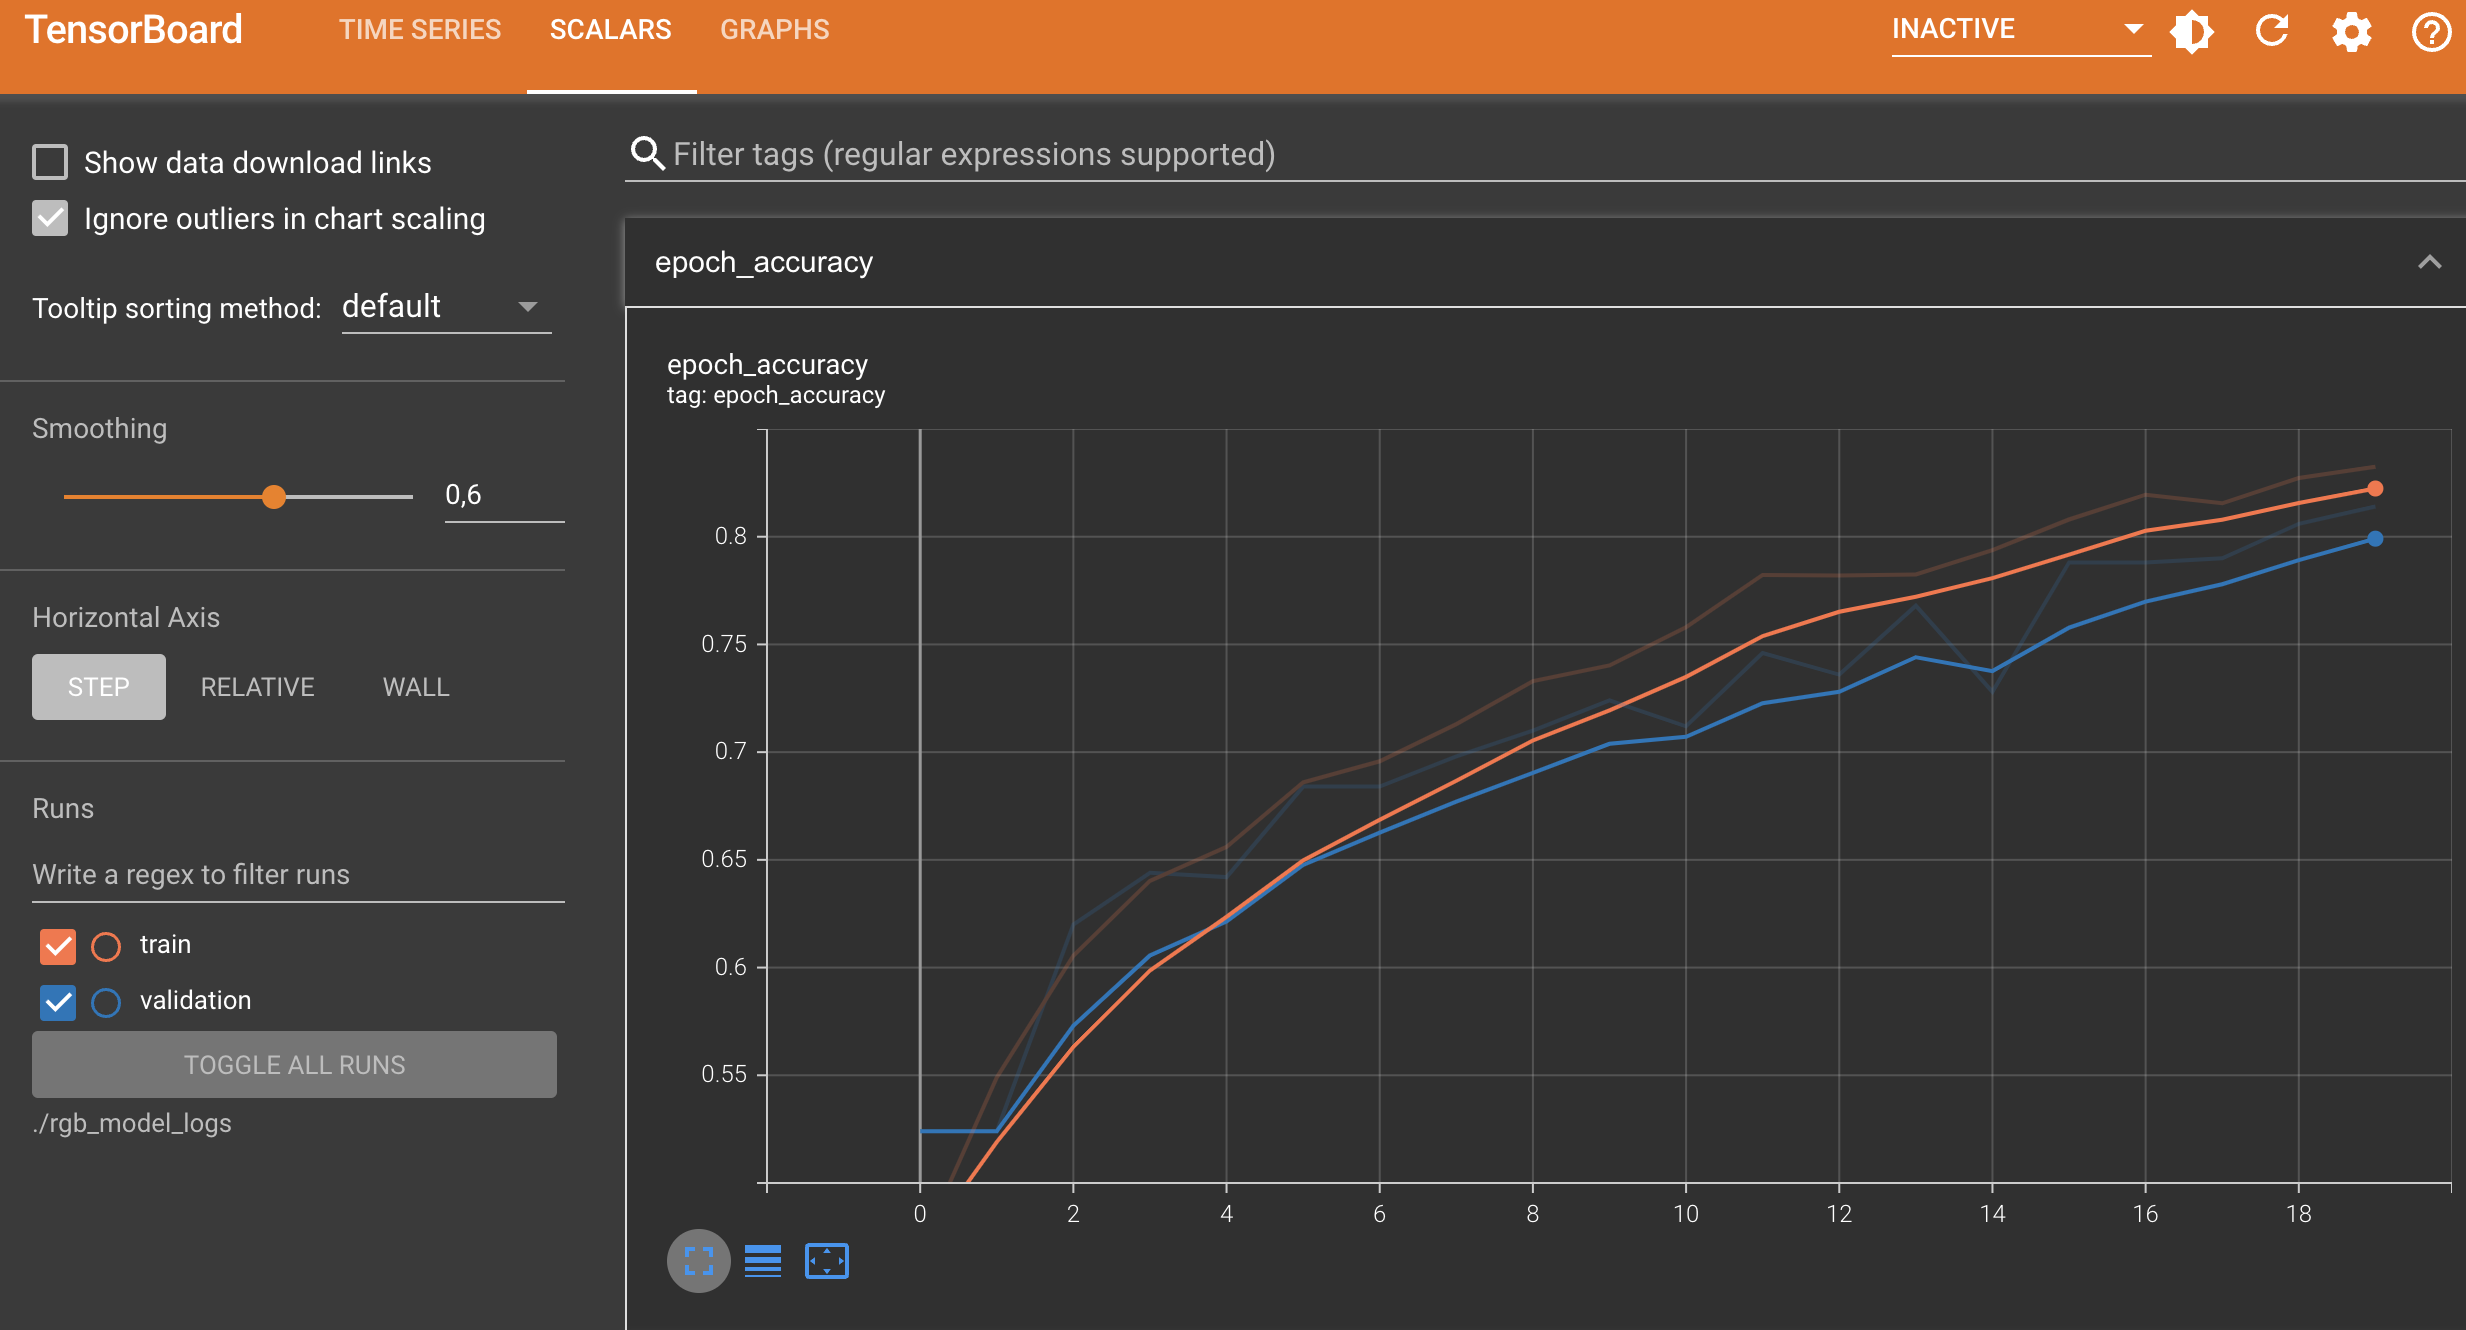
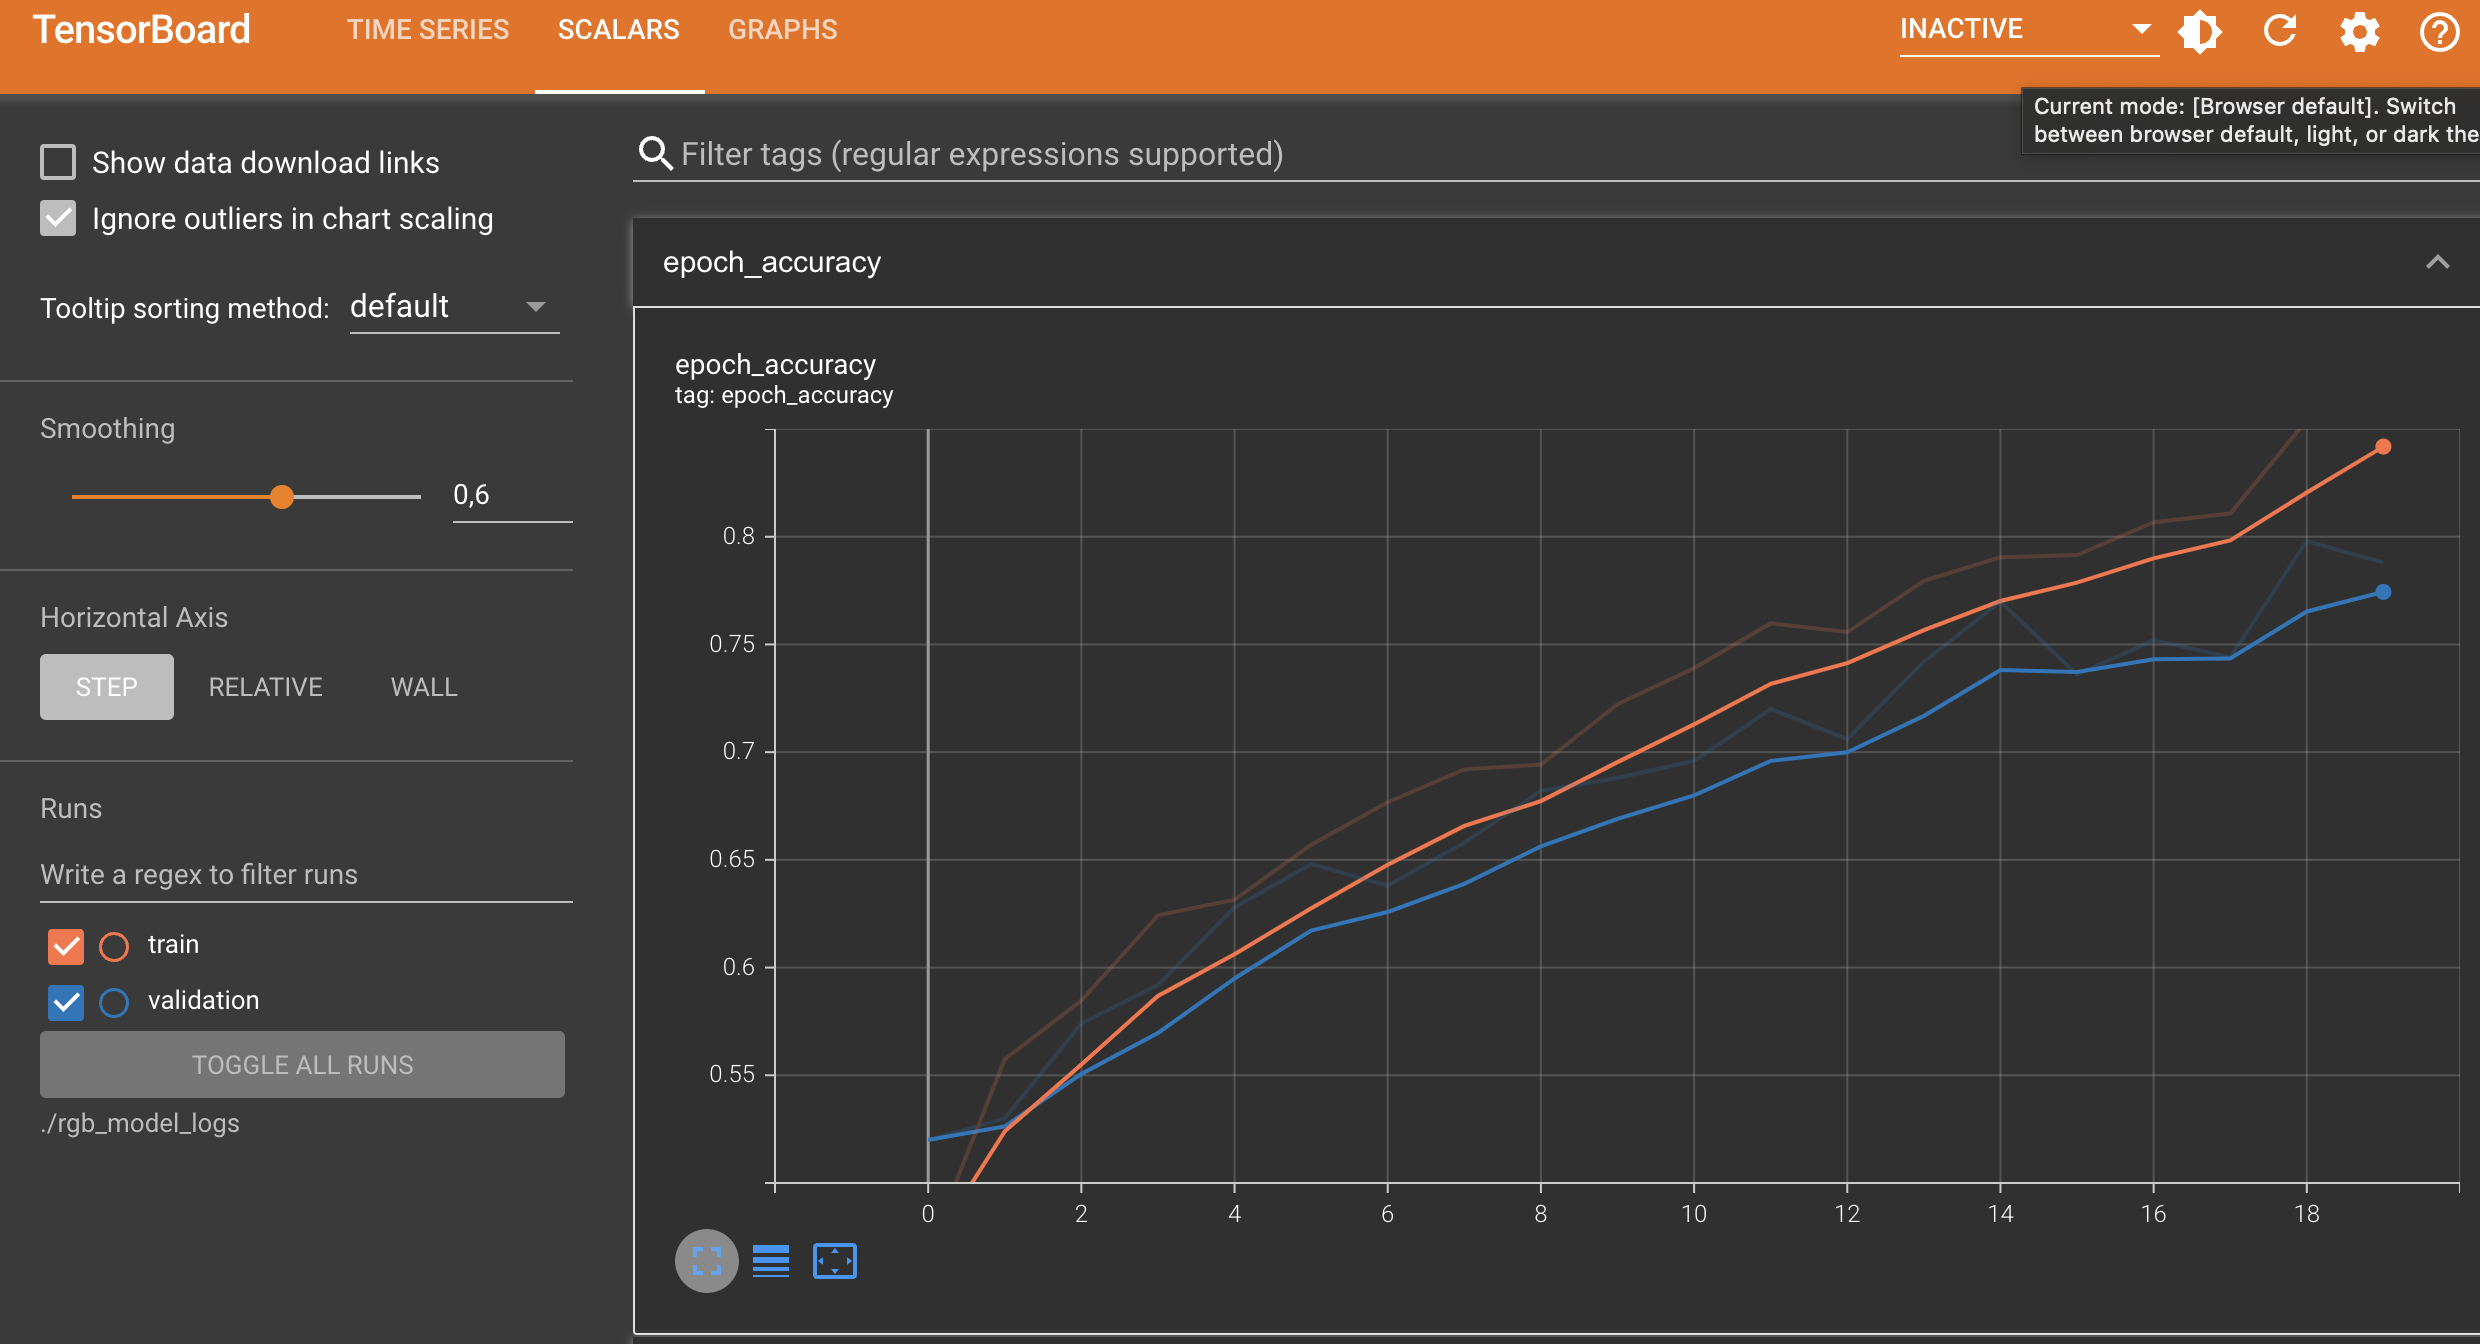
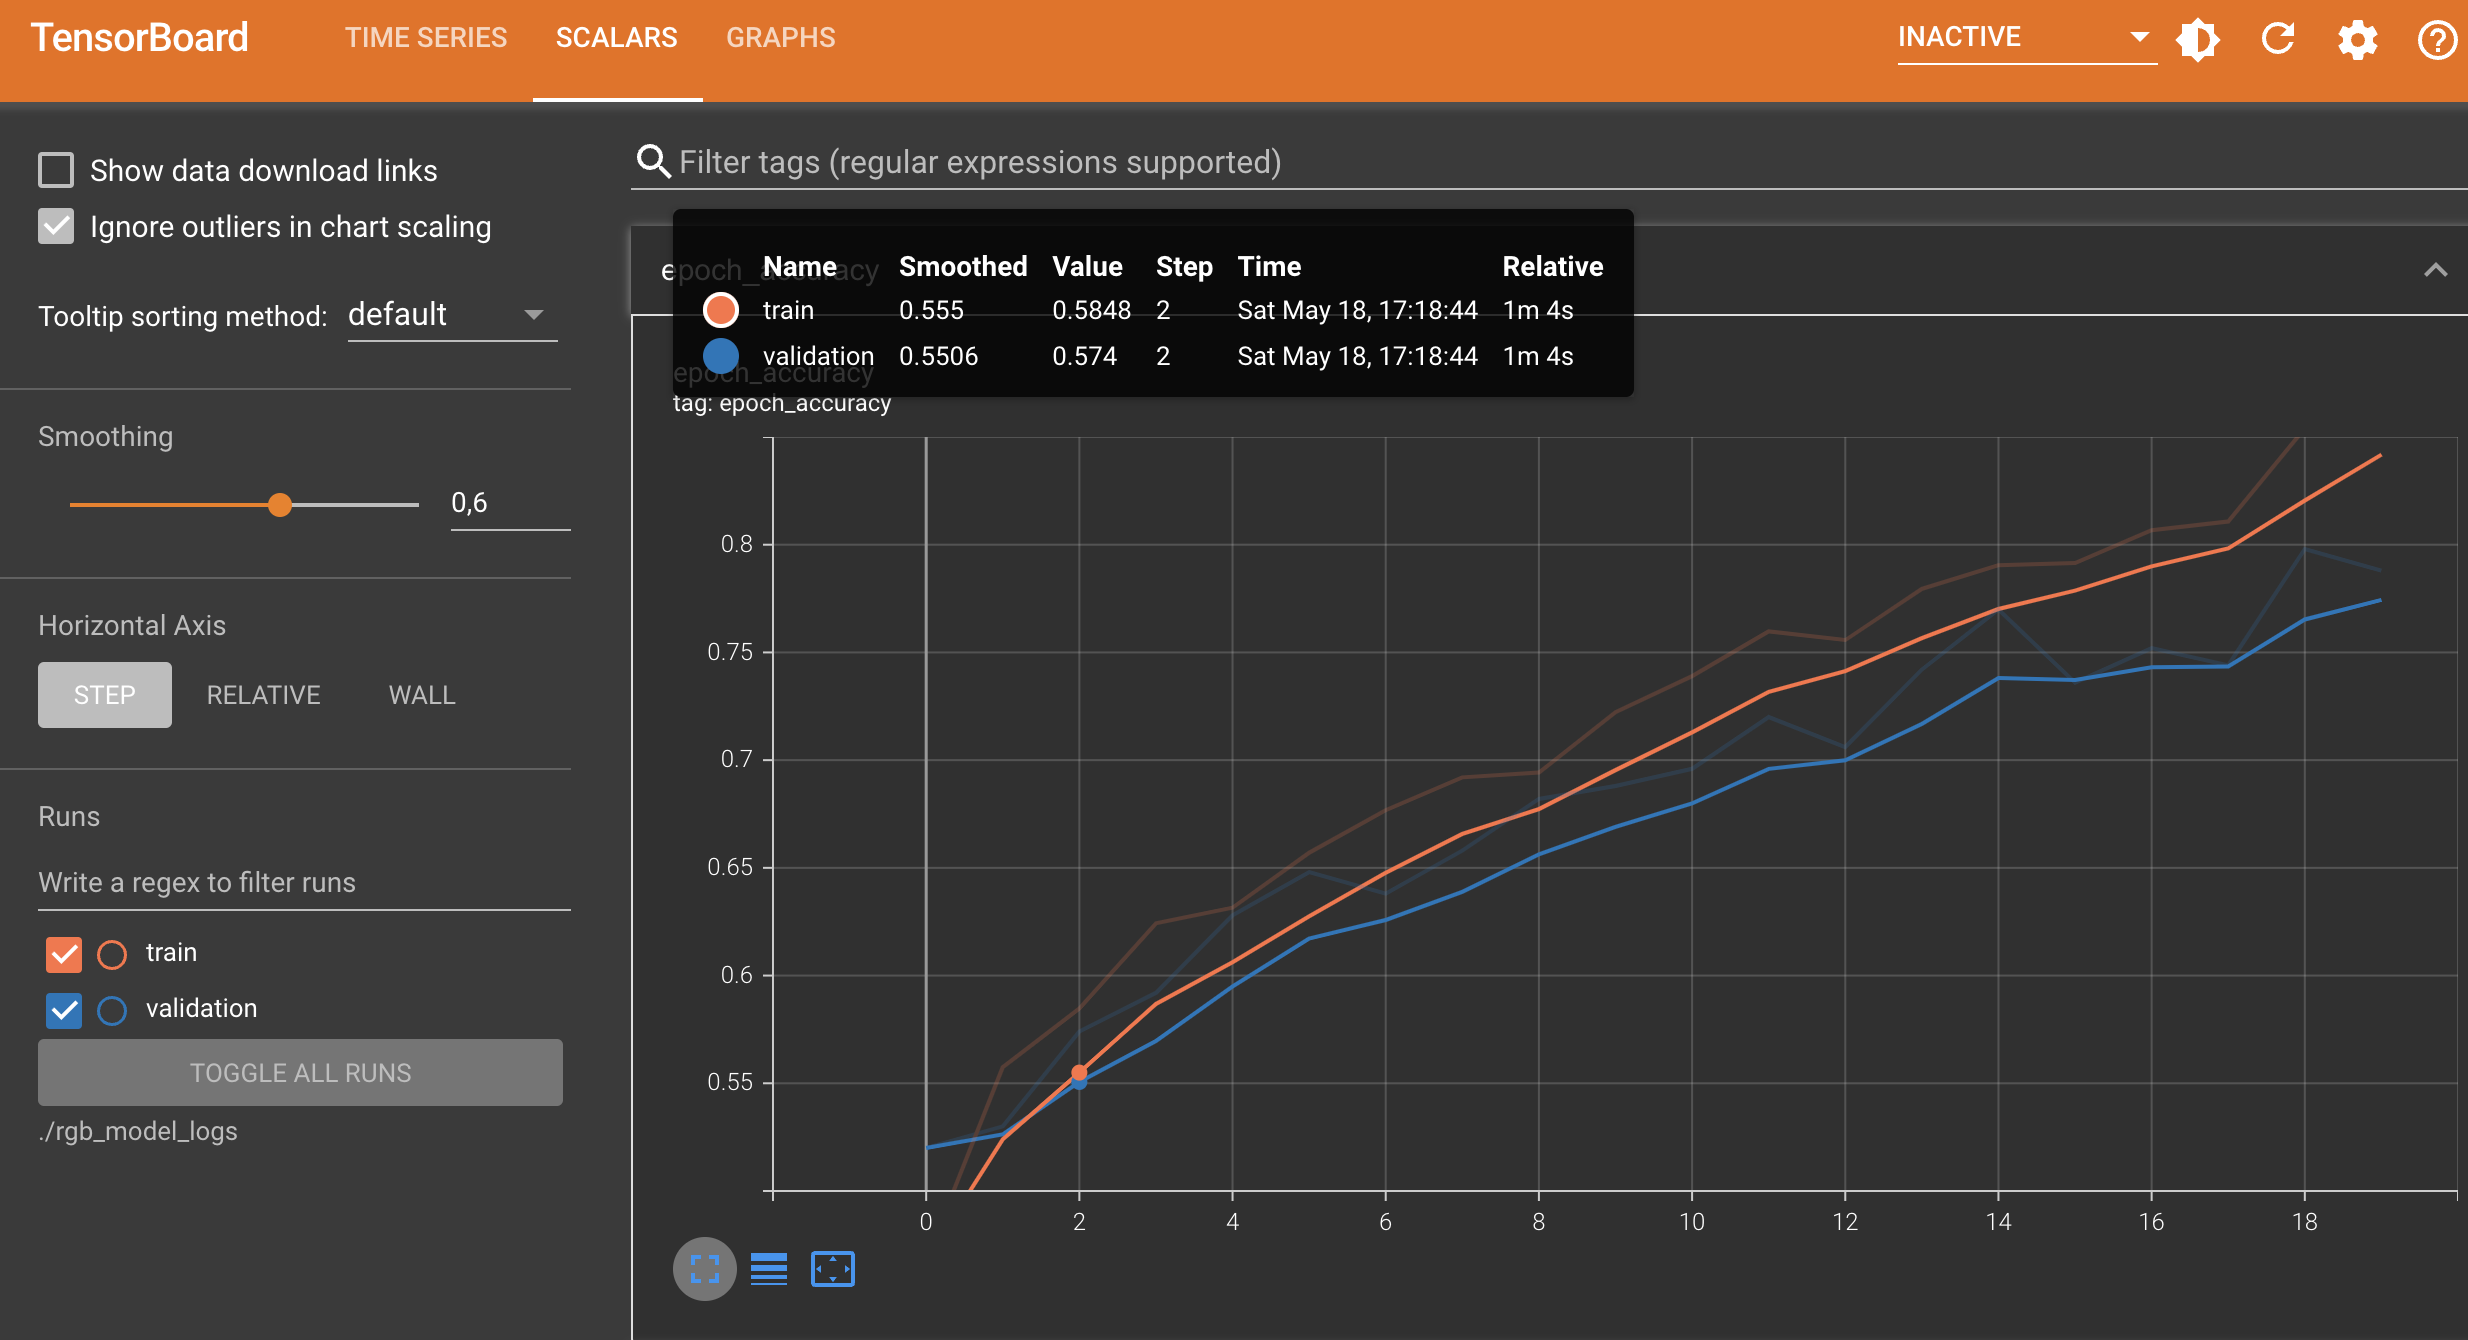

#### Loss - epochs 
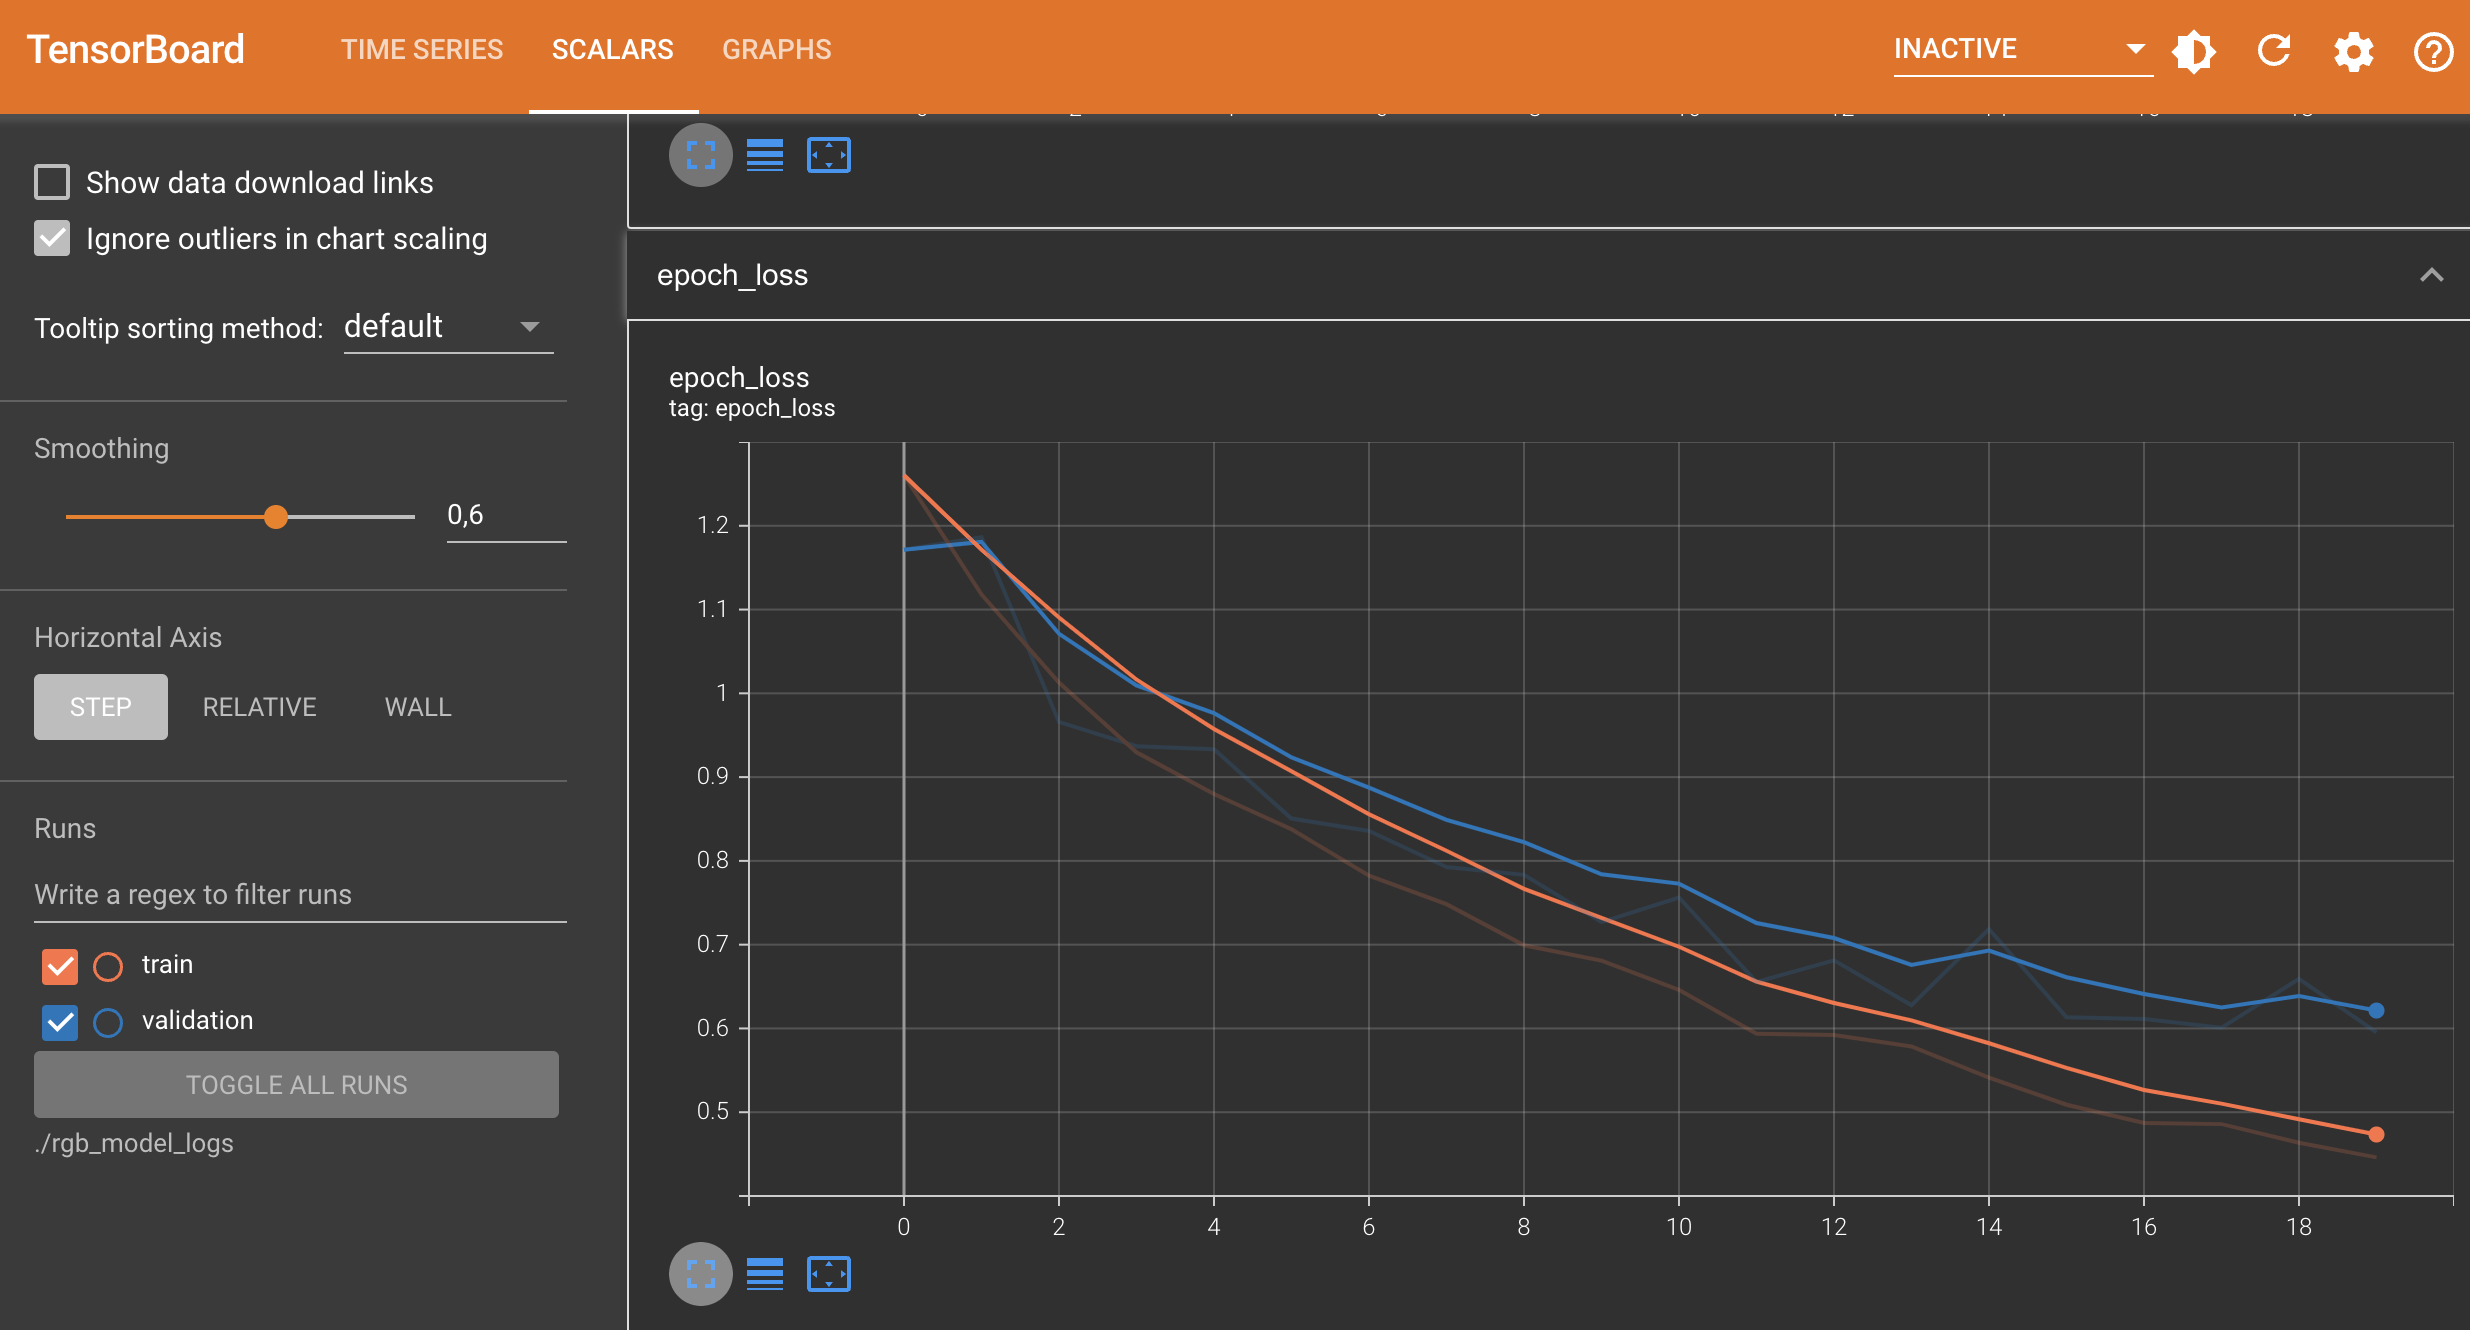
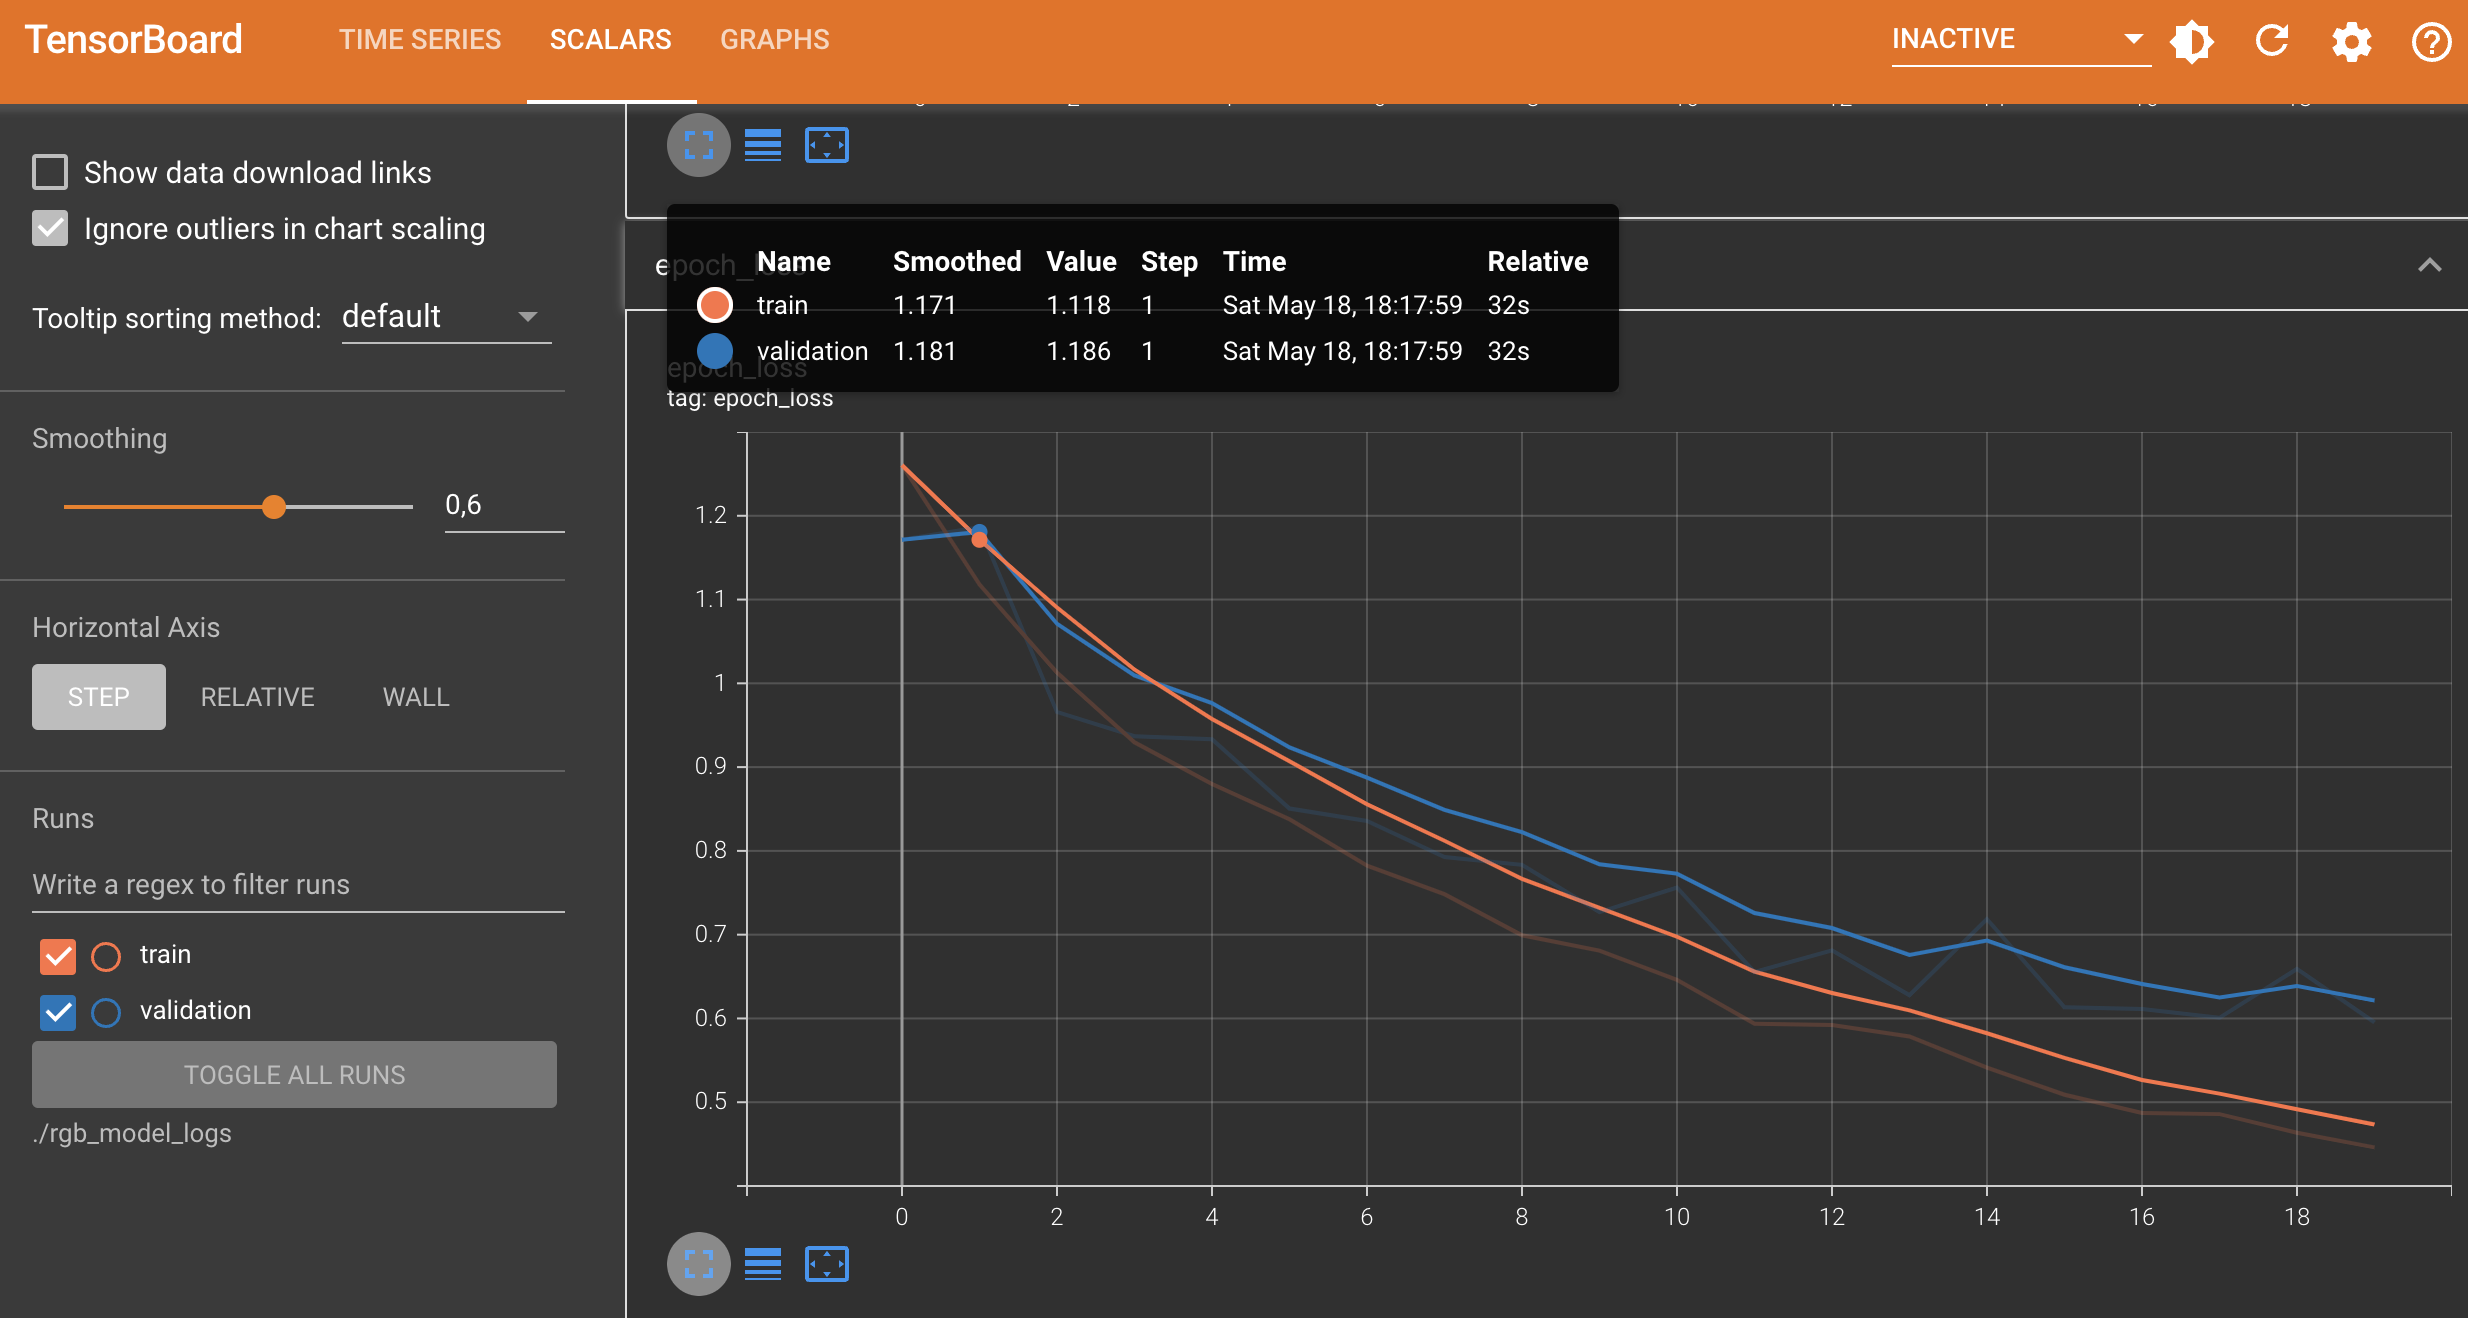
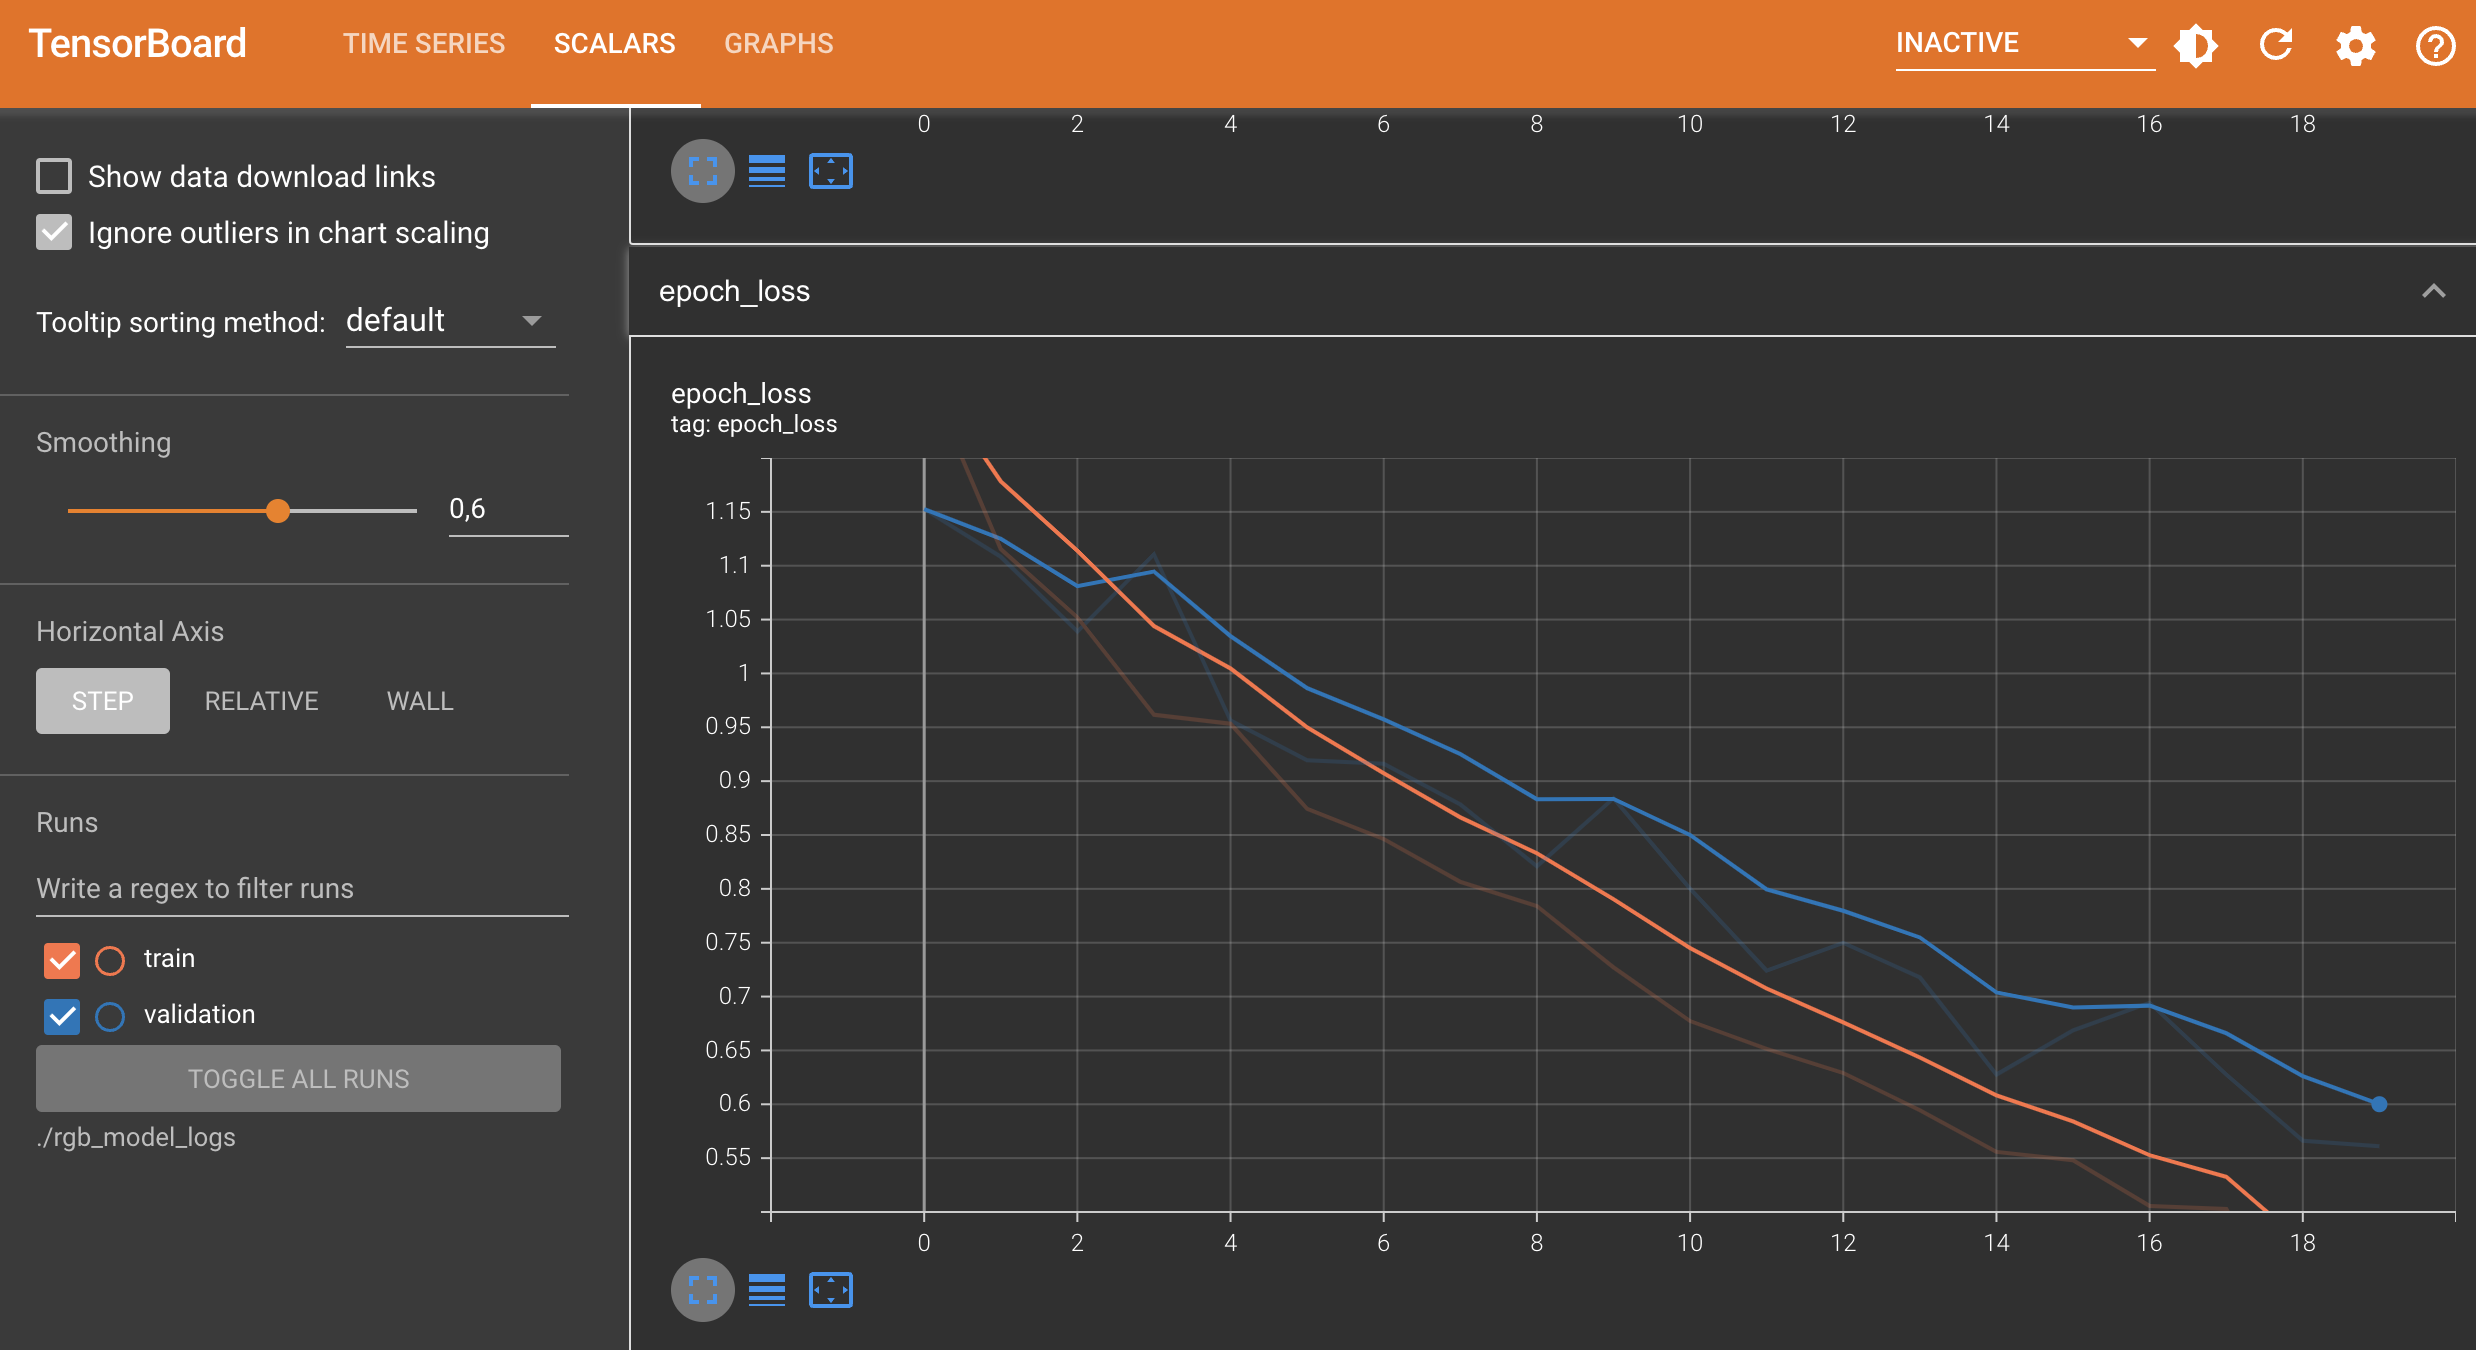

## Evaluate Model with Metrics
#### mcld4 shows best result on validation set and through training process at all. Let's see how it performs on the test set.

In [218]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = mcld4_model.evaluate(train_generator_augmented_weak, steps= test_steps, verbose= 1)
valid_score = mcld4_model.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = mcld4_model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 1s 60ms/step - loss: 0.5127 - accuracy: 0.8063
Train Loss:  0.32442203164100647
Train Accuracy:  0.887499988079071
--------------------
Valid Loss:  0.4549342691898346
Valid Accuracy:  0.8125
--------------------
Test Loss:  0.5127012133598328
Test Accuracy:  0.8062500357627869


1/1 [==============================] - 0s 201ms/step


2024-05-18 19:16:01.458187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


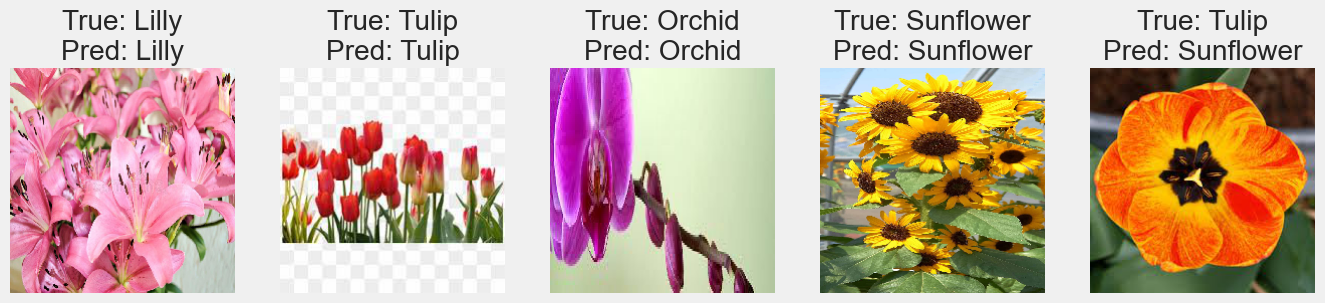

In [219]:
def show_predictions(model, test_generator, class_indices, num_images=5):
    class_labels = {v: k for k, v in class_indices.items()}
    
    test_images, test_labels = next(test_generator)
    
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        true_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

show_predictions(mcld4_model, test_generator, test_generator.class_indices, num_images=5)


## Comparison with MLP
#### Train a simple Multilayer Perceptron (MLP) for comparison:

In [95]:
mlp_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

mlp_model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_history = mlp_model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10


2024-05-18 16:48:35.463431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 183.5283 - accuracy: 0.3255

2024-05-18 16:49:11.845975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 39s 153ms/step - loss: 183.5283 - accuracy: 0.3255 - val_loss: 56.4720 - val_accuracy: 0.4120
Epoch 2/10
250/250 [==============================] - 38s 153ms/step - loss: 95.3116 - accuracy: 0.3378 - val_loss: 95.1926 - val_accuracy: 0.3060
Epoch 3/10
250/250 [==============================] - 37s 147ms/step - loss: 75.3089 - accuracy: 0.3458 - val_loss: 113.8070 - val_accuracy: 0.2280
Epoch 4/10
250/250 [==============================] - 37s 146ms/step - loss: 73.2522 - accuracy: 0.3698 - val_loss: 111.9868 - val_accuracy: 0.3020
Epoch 5/10
250/250 [==============================] - 37s 147ms/step - loss: 95.1869 - accuracy: 0.3615 - val_loss: 155.1696 - val_accuracy: 0.3380
Epoch 6/10
250/250 [==============================] - 42s 166ms/step - loss: 96.7139 - accuracy: 0.3643 - val_loss: 203.4888 - val_accuracy: 0.2640
Epoch 7/10
250/250 [==============================] - 38s 153ms/step - loss: 123.8321 - accuracy: 0.3668 - val_loss: 478.485

#### As expected we see that even two layers (512, 256) can't learn patterns in images of huge dimensions.